# Врожденный порог сердца у детей. Бинарный метод

In [1]:
# Работа с массивами данных
import numpy as np 

# Работа с таблицами
import pandas as pd

# Отрисовка графиков
import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf

import pickle

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Кодирование тестовых меток
from sklearn.preprocessing import LabelEncoder

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Отрисовка графиков
import matplotlib.pyplot as plt

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

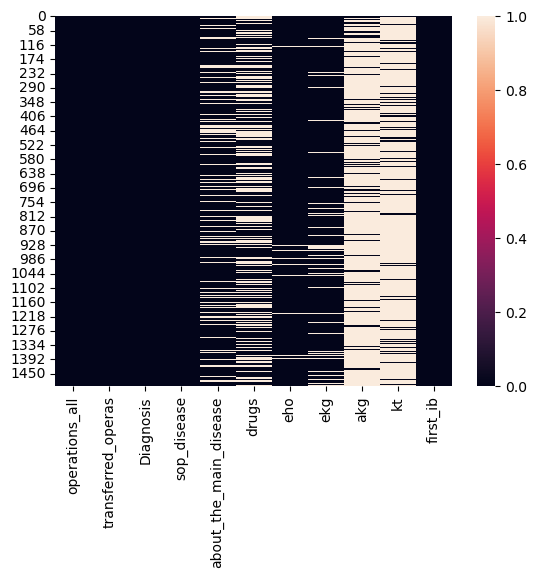

In [2]:
file_path = 'data.xlsx'
dataframe = pd.read_excel(file_path).drop(['birth','admittion','discharge', 'Дата опер.'], axis=1)
dataframe = dataframe.rename(columns={
                                      'Операции (все в ИБ)':'operations_all',
                                      'Перенесенные опер. (из Анамн.)':'transferred_operas',
                                      'Диагноз':'Diagnosis',
                                      'МКБ':'mkg',
                                      'Соп. забол. (из Анамн.)':'sop_disease',
                                      'Медикам. леч. по поводу осн. забол. (из Анамн.)':'about_the_main_disease', 
                                      'Принимаемые препараты (из Анамн.)':'drugs',
                                      'ЭхоКГ (Из Эпикр. до опер.)':'eho',
                                      'ЭКГ (Из Эпикр. до опер.)':'ekg',
                                      'АКГ (Из Эпикр. до опер.)':'akg',
                                      'КТ (Из Эпикр. до опер.)':'kt',
                                      'Операция (основная / первая в ИБ)':'first_ib'
                                     })

dataframe = dataframe.loc[:,'operations_all':'target'].drop('mkg', axis=1)#.fillna('')

sns.heatmap(dataframe.drop('target',axis=1).isnull());


## Анализ эффективности моделей нейронных сетей на признаках
 
Обучено по 96 моделей на каждый признак. От каждого признака взяли лучшую модель. Обучение в тетрадке VPS_features_score

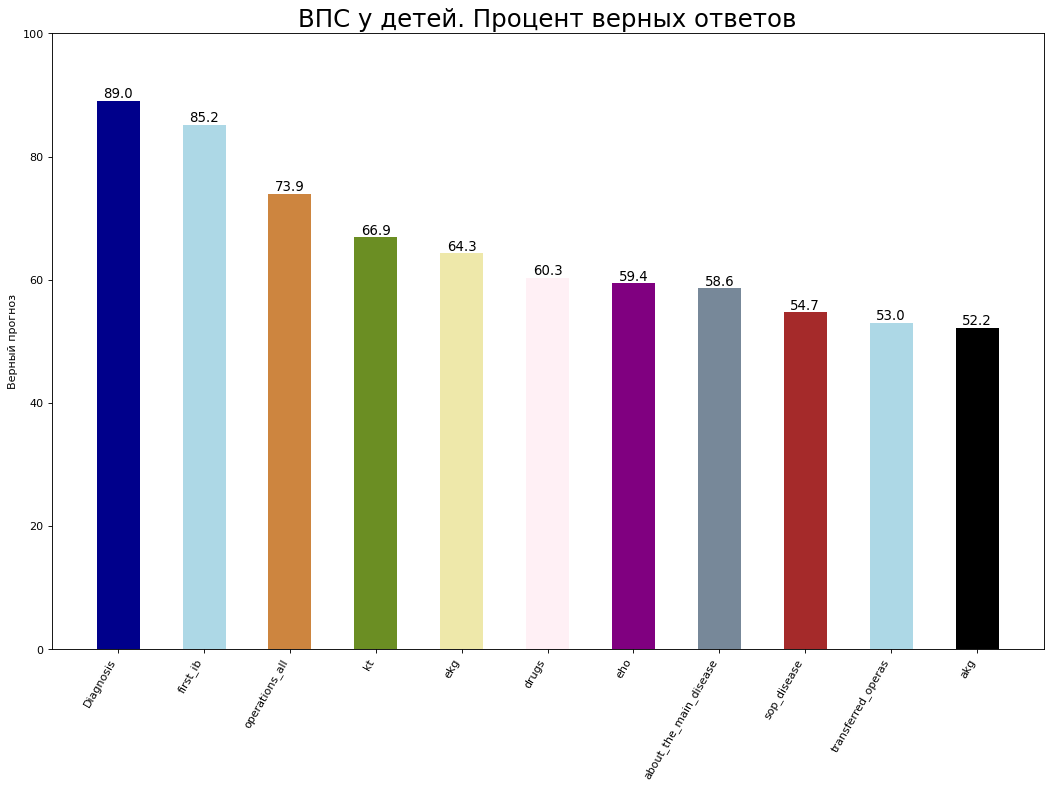

,Unnamed: 0,tn,tp,val_loss,val_accuracy,activation,loss_f,metrics,category,bow,categorical_crossentropy,val_categorical_crossentropy,score
2,Diagnosis,0.947,0.833,0.463522,0.923333,tanh,binary_crossentropy,BinaryAccuracy,False,False,NaN,NaN,89.0
10,first_ib,0.872,0.833,0.632383,0.870000,sigmoid,hinge,BinaryAccuracy,False,False,NaN,NaN,85.2
0,operations_all,0.922,0.556,0.202949,0.898333,tanh,hinge,BinaryAccuracy,False,True,NaN,NaN,73.9
9,kt,0.894,0.444,1.911298,0.471667,relu,binary_crossentropy,BinaryAccuracy,False,False,NaN,NaN,66.9
7,ekg,0.730,0.556,0.790225,0.713333,sigmoid,hinge,BinaryAccuracy,False,False,NaN,NaN,64.3
5,drugs,0.762,0.444,0.762934,0.565000,tanh,hinge,BinaryAccuracy,False,False,NaN,NaN,60.3
6,eho,0.911,0.278,0.711329,0.871667,relu,hinge,BinaryAccuracy,False,True,NaN,NaN,59.4
4,about_the_main_disease,0.840,0.333,0.739800,0.805000,relu,hinge,BinaryAccuracy,False,True,NaN,NaN,58.6
3,sop_disease,0.316,0.778,0.865056,0.501667,tanh,binary_crossentropy,BinaryAccuracy,False,False,NaN,NaN,54.7
1,transferred_operas,0.170,0.889,0.742070,0.503333,sigmoid,binary_crossentropy,BinaryAccuracy,False,False,NaN,NaN,53.0


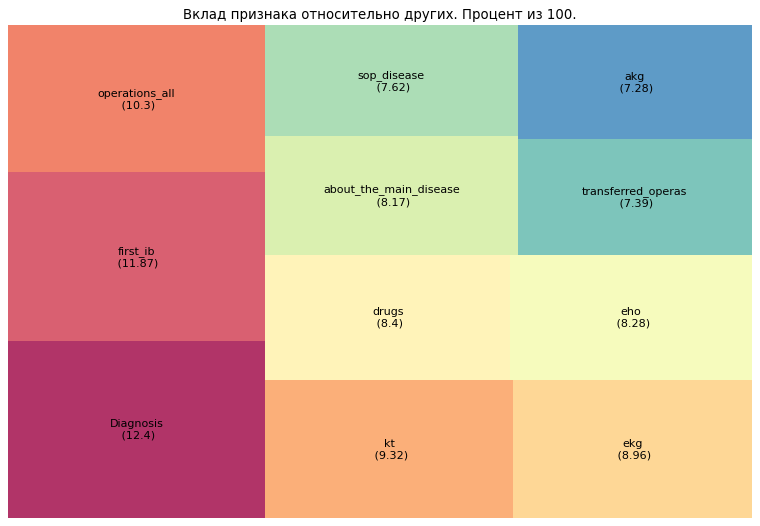

In [3]:
#data = pd.DataFrame()
#for label in dataframe.drop('target',axis=1).columns:
#    row = pd.read_csv(f'{label}_feature_data.csv').sort_values(['score'], ascending=False).head(1)
#    row['Unnamed: 0'] = label
#    data = pd.concat([data, row])
#display(data)
#data.to_csv(f'all_feature_data_scores.csv')

from matplotlib import pyplot as plt
import random
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

df = (pd.read_csv(f'all_feature_data_scores.csv')
        .sort_values(['score'], ascending=False)
        .drop(['Unnamed: 0.1',
               'fn','fp','loss','accuracy'], axis=1))
df['score'] = round(df['score']*100,1)

f, s = 'Unnamed: 0', 'score'
n = df[f].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df[f], df[s], color=c, width=.5)
for i, val in enumerate(df[s].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

# Decoration
plt.gca().set_xticklabels(df[f], rotation=60, horizontalalignment= 'right')
plt.title("ВПС у детей. Процент верных ответов", fontsize=22)
plt.ylabel('Верный прогноз')
plt.ylim(0, 100)
plt.show()

display(df)

# pip install squarify
import squarify 
# Prepare Data
data = df[['Unnamed: 0', 'score']]
data['score'] = [round(x/data['score'].sum()*100,2) for x in data['score']]
df = data
labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df['score'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
# Decorate
plt.title('Вклад признака относительно других. Процент из 100.')
plt.axis('off')
plt.show()

In [4]:
# Задание параметров преобразования
VOCAB_SIZE       = 30000                  # Объем словаря для токенизатора
TRAIN_TEST_RATIO = 0.2                    # Доля проверочной выборки в основном наборе

# Извлечение всех записей-текстов обращений и их меток классов
target = 'target'
feature = 'Diagnosis'
dataframe = dataframe.loc[dataframe[feature].dropna().index]

text_data = dataframe[feature].tolist()
class_data = dataframe[target].tolist()

In [5]:
# Токенизация и построение частотного словаря по обучающим текстам
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_data)

# Сохраняем обученный Tokenizer в файл
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())

# Кодирование меток классов индексами (числами)
encoder = LabelEncoder()
class_labels = encoder.fit_transform(class_data)

CLASS_LIST = encoder.classes_
CLASS_COUNT = len(CLASS_LIST)

print(f'Размер словаря: {len(items)}')
print(f'Список классов: {CLASS_LIST}')
print(f'Всего классов: {CLASS_COUNT}')
print(f'Форма выходных данных: {class_labels.shape}')
print(f'Пример числовых меток классов: {class_labels[:10]}')

print('Преобразование входных текстов в последовательности индексов (для архитектур с embedding)')
print('Применено приведение к массиву объектов для дальнейшего разделения на выборки. x_data')
x_data = np.array(tokenizer.texts_to_sequences(text_data), dtype=object)
print(x_data.shape) 
print(x_data[0][:20])

print('Преобразование входных текстов в разреженную матрицу из векторов Bag of Words. x_data_01')
x_data_01 = tokenizer.texts_to_matrix(text_data)
print(x_data_01.shape) 
print(x_data_01[0, :20])

print('Преобразование меток класса к векторам one hot encoding. y_data')
y_data = utils.to_categorical(class_labels, CLASS_COUNT)
print(y_data.shape)
print(y_data[0])

print('Получение индексов разделения основного набора на обучающую и тестовую выборки')
idx_train, idx_test = train_test_split(list(range(len(x_data))),
                                       stratify=y_data,
                                       test_size=TRAIN_TEST_RATIO)

print('Разделение в соответствии с полученными индексами')
x_train, x_test = x_data[idx_train], x_data[idx_test]
x_train_01, x_test_01 = x_data_01[idx_train], x_data_01[idx_test]
y_train, y_test = y_data[idx_train], y_data[idx_test]

# Проверка результата
print('x_train.shape, x_test.shape')
print(x_train.shape, x_test.shape)
print('x_train_01.shape, x_test_01.shape')
print(x_train_01.shape, x_test_01.shape)
print('y_train.shape, y_test.shape')
print(y_train.shape, y_test.shape)

# train и test для Embedding
# Снижение размерности входных данных:
# ограничение длины последовательностей до разумного предела
seq_max_len = 400
print('Ограничение:', seq_max_len)
x_train_clip = pad_sequences(x_train, maxlen=seq_max_len)
x_test_clip = pad_sequences(x_test, maxlen=seq_max_len)

# Проверка формы результата
print('x_train_clip.shape, x_test_clip.shape')
print(x_train_clip.shape, x_test_clip.shape)

print('Веса классов для балансировки.')
neg, pos = np.bincount(dataframe['target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Размер словаря: 2762
Список классов: [0 1]
Всего классов: 2
Форма выходных данных: (1500,)
Пример числовых меток классов: [0 0 0 0 0 0 0 0 0 0]
Преобразование входных текстов в последовательности индексов (для архитектур с embedding)
Применено приведение к массиву объектов для дальнейшего разделения на выборки. x_data
(1500,)
[88, 7, 6, 11, 81, 183, 415, 19, 18, 1574, 614, 41, 40, 36, 26, 244, 115, 7, 6, 64]
Преобразование входных текстов в разреженную матрицу из векторов Bag of Words. x_data_01
(1500, 30000)
[0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.]
Преобразование меток класса к векторам one hot encoding. y_data
(1500, 2)
[1. 0.]
Получение индексов разделения основного набора на обучающую и тестовую выборки
Разделение в соответствии с полученными индексами
x_train.shape, x_test.shape
(1200,) (300,)
x_train_01.shape, x_test_01.shape
(1200, 30000) (300, 30000)
y_train.shape, y_test.shape
(1200, 2) (300, 2)
Ограничение: 400
x_train_clip.shape, x_test_clip.shape
(1200,

## Итог отбора

In [6]:
activation = 'tanh' # 'sigmoid', 'tanh', 'relu'
loss = 'binary_crossentropy' # 'hinge', 'binary_crossentropy'
optimizer = 'adam' # 'rmsprop', 'adam'
metrics = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=pos/total)


In [87]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model, 
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam', 
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss=loss,
                  metrics=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=pos/total)
                 )

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        # The class weights go here
                        class_weight=class_weight,
                        verbose=0)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['binary_accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_binary_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model, 
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test, 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

### BagOfWords + Dense

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3000100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2

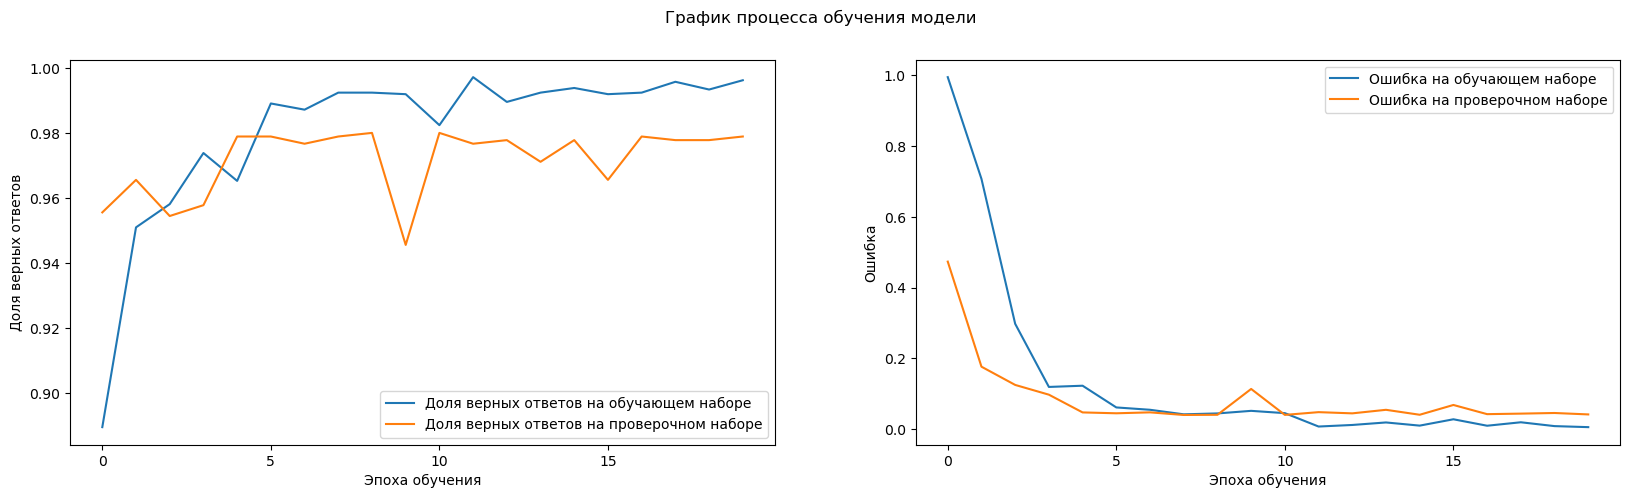

15/15 [==============================] - 0s 3ms/step


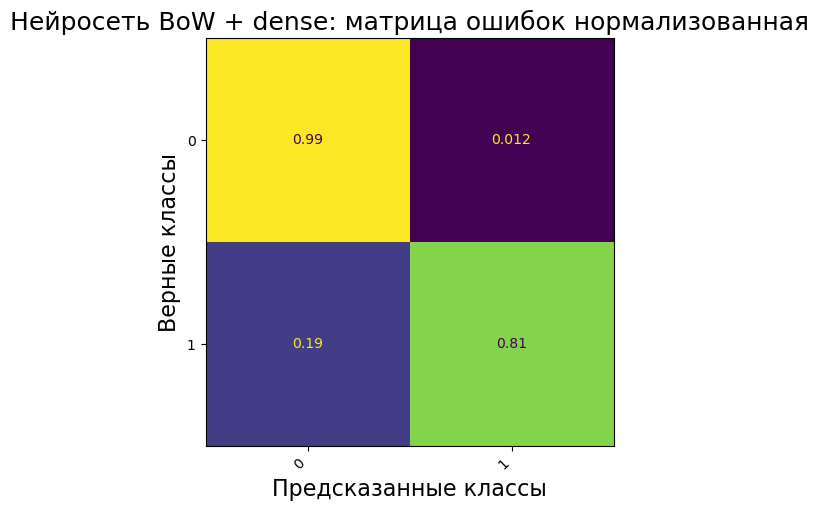

----------------------------------------------------------------------------------------------------
Нейросеть: BoW + dense
Класс: 0                     99% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     81% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  90%


In [12]:
# Последовательная модель
model_text_bow_dense = Sequential()
# Входной полносвязный слой
model_text_bow_dense.add(Dense(100, input_dim=VOCAB_SIZE, activation="relu"))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Второй полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Третий полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Выходной полносвязный слой
model_text_bow_dense.add(Dense(CLASS_COUNT, activation=activation))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_dense,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='BoW + dense')

### Embedding + Dense

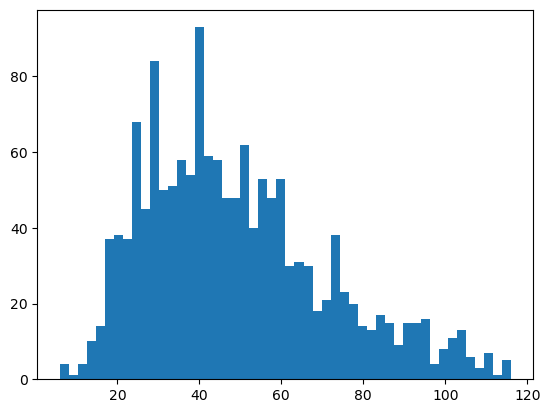

In [15]:
# Построение гистограммы распределения длин текстов основного набора
seq_len = [len(x) for x in x_data]
plt.hist(seq_len, 50)
plt.show()

In [16]:
# Снижение размерности входных данных:
# ограничение длины последовательностей до разумного предела
seq_max_len = 400
x_train_clip = pad_sequences(x_train, maxlen=seq_max_len)
x_test_clip = pad_sequences(x_test, maxlen=seq_max_len)

# Проверка формы результата
print(x_train_clip.shape, x_test_clip.shape)

(1050, 400) (450, 400)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 50)           1500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 400, 50)          0         
 ropout1D)                                                       
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 batch_normalization (BatchN  (None, 20000)            80000     
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 64)                1280064   
                                                                 
 dropout_3 (Dropout)         (None, 64)               

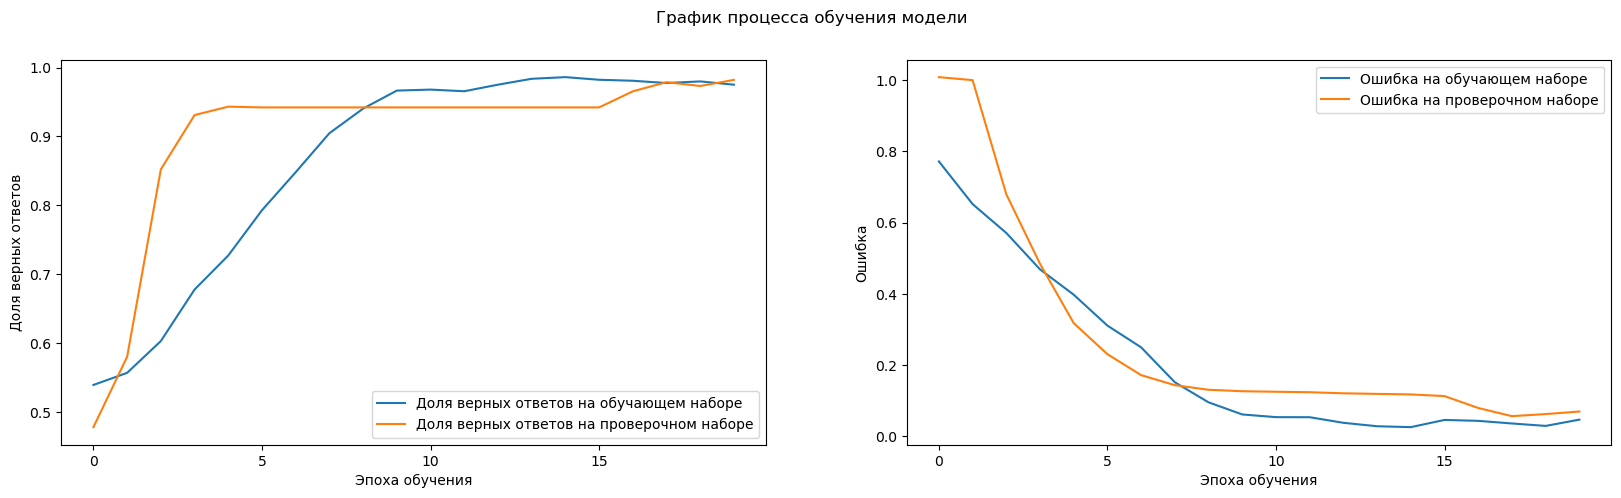

15/15 [==============================] - 0s 2ms/step


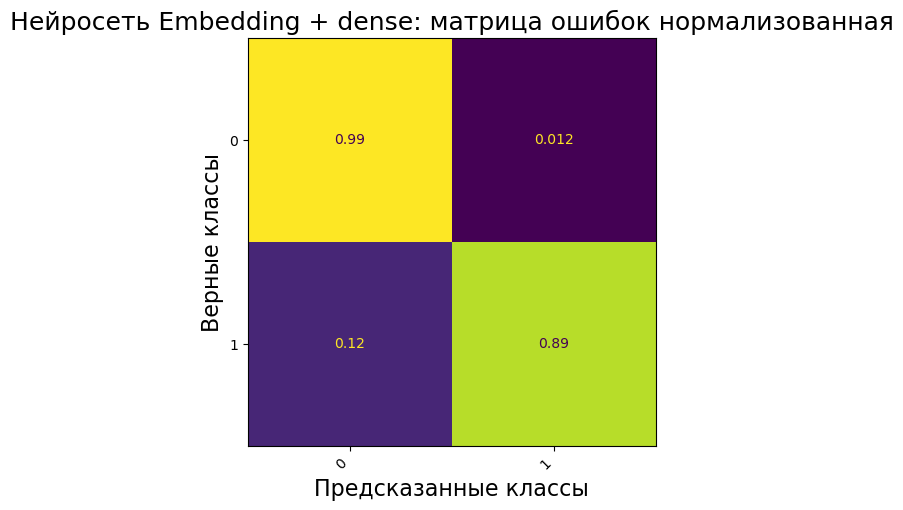

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding + dense
Класс: 0                     99% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     88% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  94%


In [15]:
# Последовательная модель
model_text_emb_dense = Sequential()
# Cлой эмбеддингов
model_text_emb_dense.add(Embedding(VOCAB_SIZE, 50, input_length=seq_max_len))
# Слой регуляризации Dropout
model_text_emb_dense.add(SpatialDropout1D(0.2))
# Cлой преобразования многомерных данных в одномерные
model_text_emb_dense.add(Flatten())
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Полносвязный слой
model_text_emb_dense.add(Dense(64, activation="relu"))
# Слой регуляризации Dropout
model_text_emb_dense.add(Dropout(0.2))
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Выходной полносвязный слой
model_text_emb_dense.add(Dense(CLASS_COUNT, activation=activation))

compile_train_eval_model(model_text_emb_dense,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='Embedding + dense')

In [20]:
# save
#model_text_emb_dense.save('model_text_emb_dense')
#model_text_bow_dense.save('model_text_bow_dense')
# load
#import tensorflow
#model_loaded = tensorflow.keras.models.load_model('model_text_emb_dense')
# model_loaded.evaluate(x_test_clip, y_test)

## Проверка других архитектур

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_73 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_73 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_134 (Ba  (None, 400, 5)           20        
 tchNormalization)                                               
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 4)                 40        
                                                                 
 dropout_107 (Dropout)       (None, 4)                 0         
                                                                 
 dense_156 (Dense)           (None, 2)               

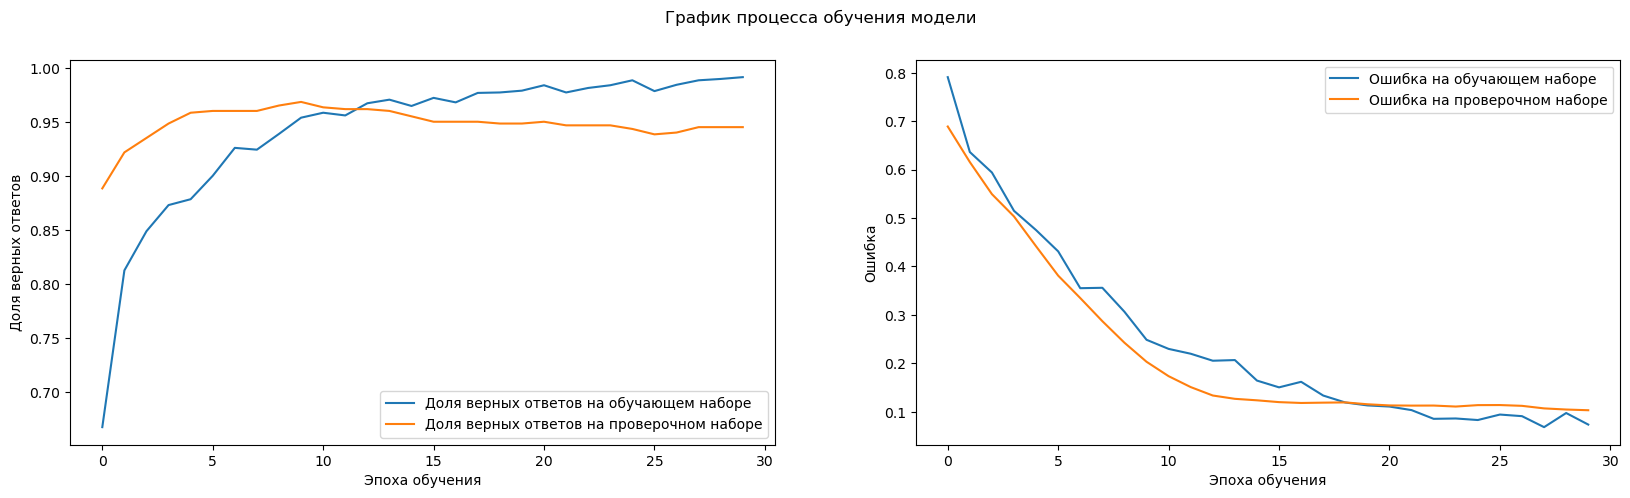

10/10 [==============================] - 1s 86ms/step


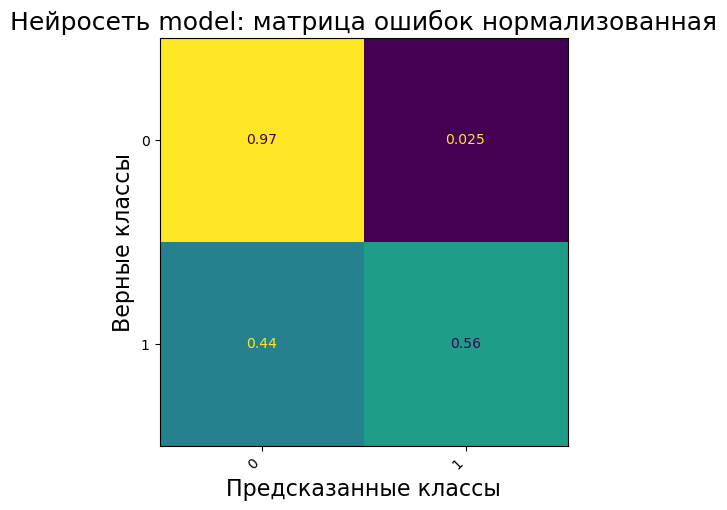

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     98% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     56% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  77%
10/10 [==============================] - 1s 85ms/step


INFO:tensorflow:Assets written to: model_plus\assets


INFO:tensorflow:Assets written to: model_plus\assets


Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_74 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_74 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_135 (Ba  (None, 400, 5)           20        
 tchNormalization)                                               
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 20)                520       
                                                                 
 dropout_108 (Dropout)       (None, 20)                0         
                                                                 
 dense_157 (Dense)           (None, 2)               

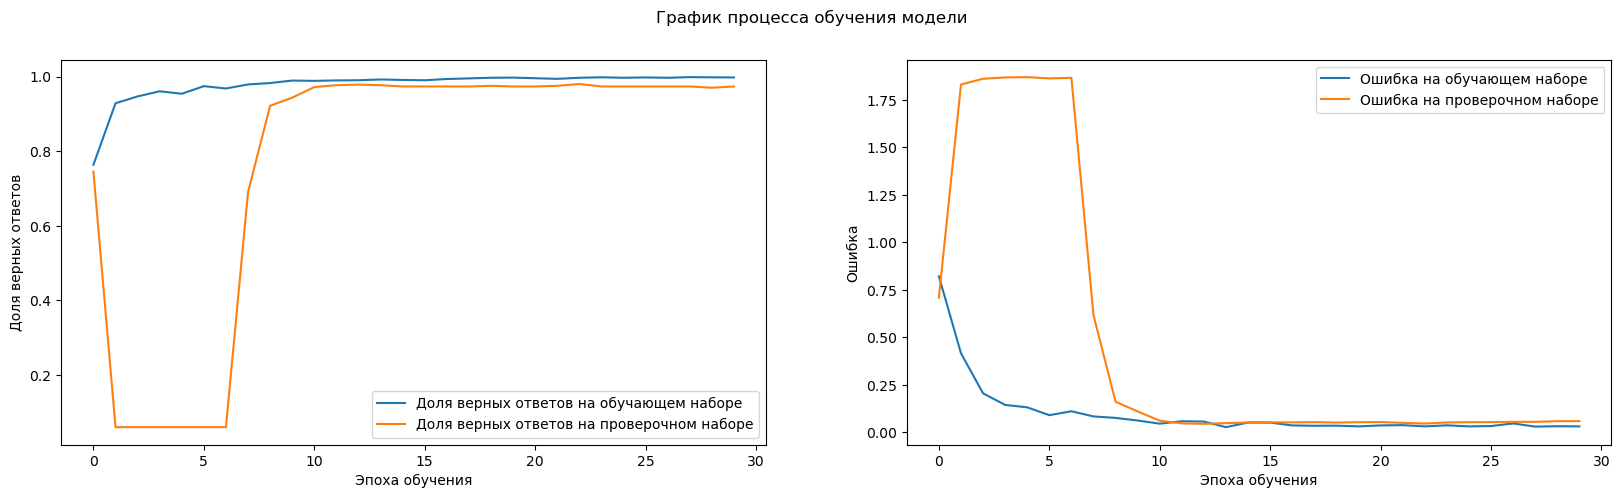

10/10 [==============================] - 1s 82ms/step


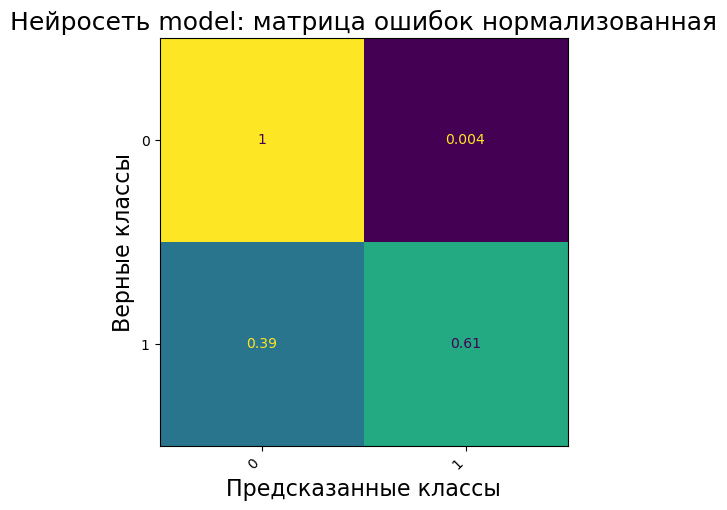

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     61% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  80%
10/10 [==============================] - 1s 81ms/step


INFO:tensorflow:Assets written to: model_plus\assets


INFO:tensorflow:Assets written to: model_plus\assets


Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_75 (Embedding)    (None, 400, 100)          3000000   
                                                                 
 spatial_dropout1d_75 (Spati  (None, 400, 100)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_136 (Ba  (None, 400, 100)         400       
 tchNormalization)                                               
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 20)                2420      
                                                                 
 dropout_109 (Dropout)       (None, 20)                0         
                                                                 
 dense_158 (Dense)           (None, 2)               

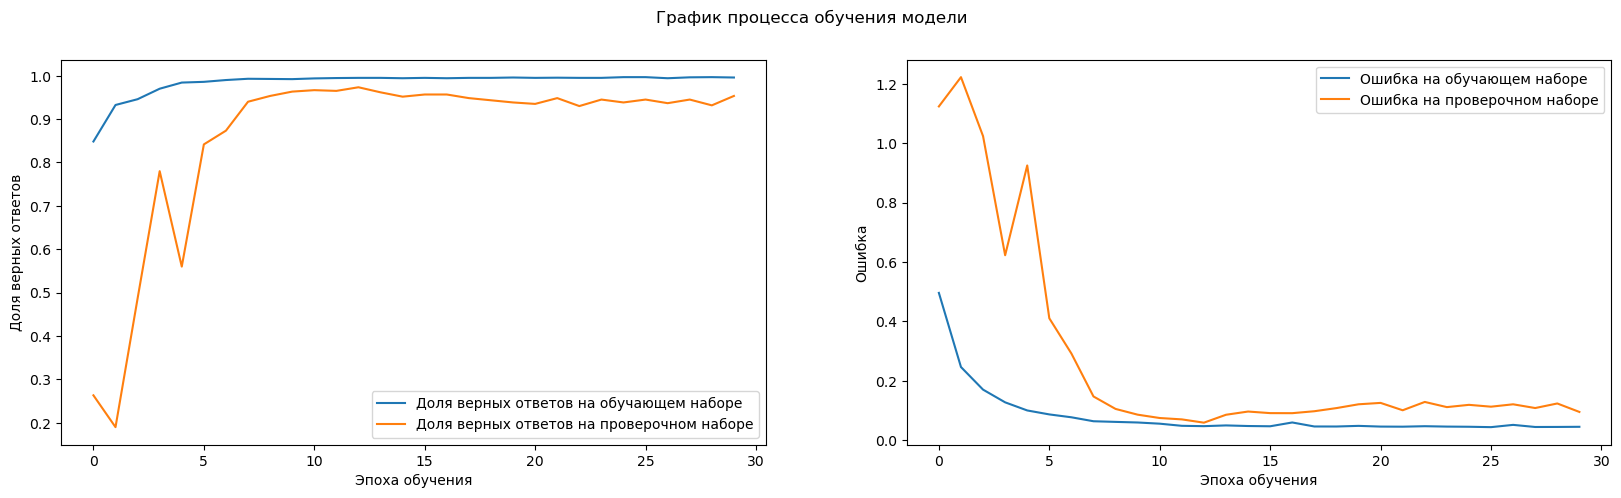

10/10 [==============================] - 8s 91ms/step


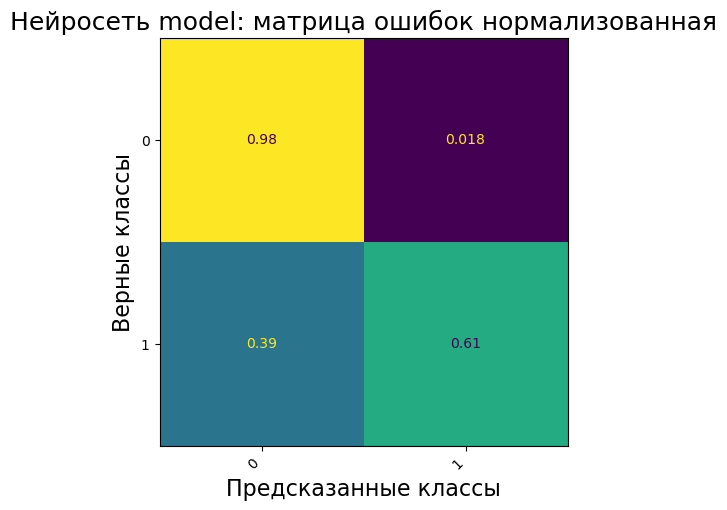

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     98% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     61% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  80%
10/10 [==============================] - 6s 91ms/step
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_76 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_76 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_137 (Ba  (None, 400, 5)           20        
 tchNormalization)                                             

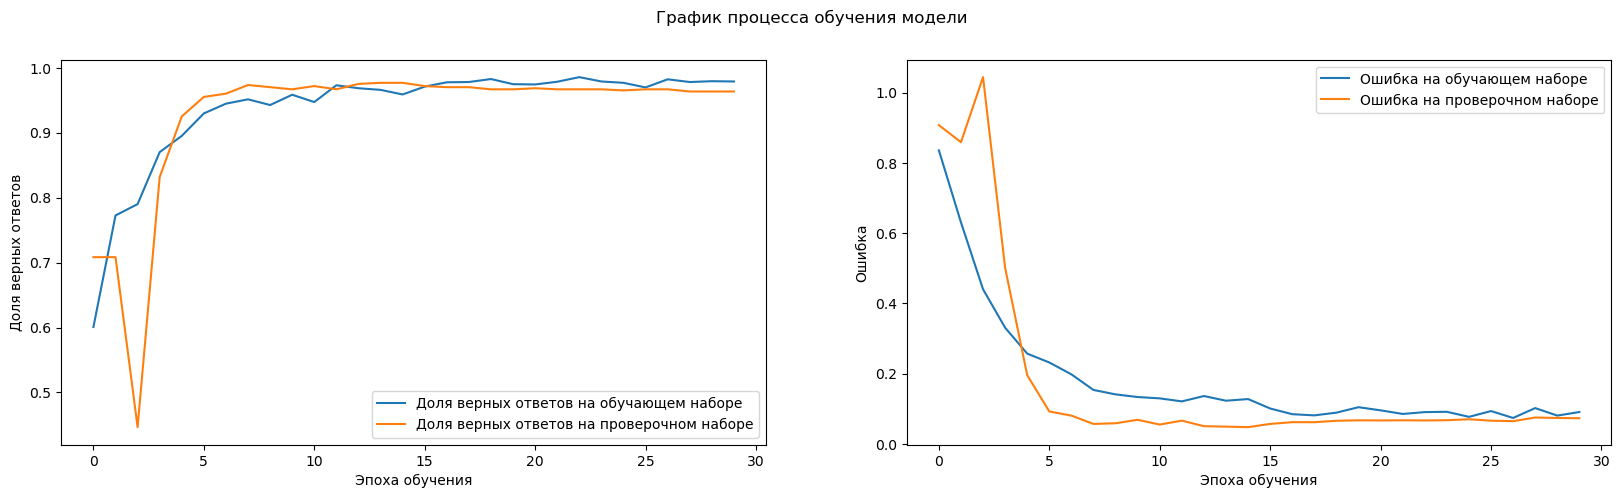

10/10 [==============================] - 8s 82ms/step


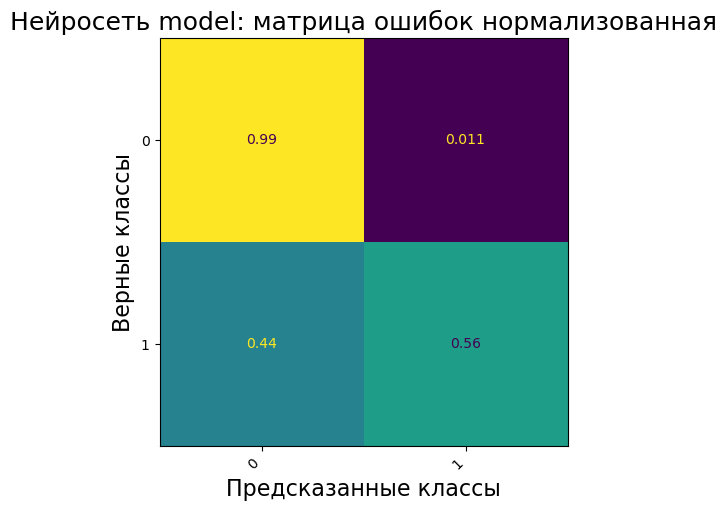

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     99% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     56% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  77%
10/10 [==============================] - 6s 82ms/step
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_77 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_77 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_138 (Ba  (None, 400, 5)           20        
 tchNormalization)                                             

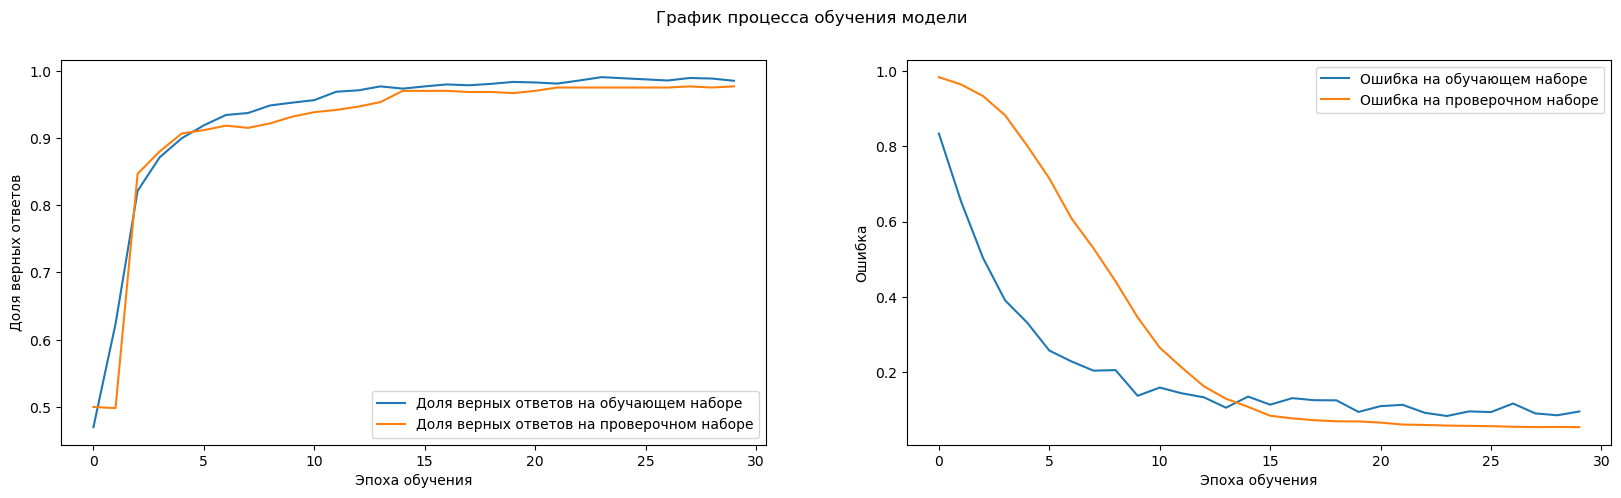

10/10 [==============================] - 3s 245ms/step


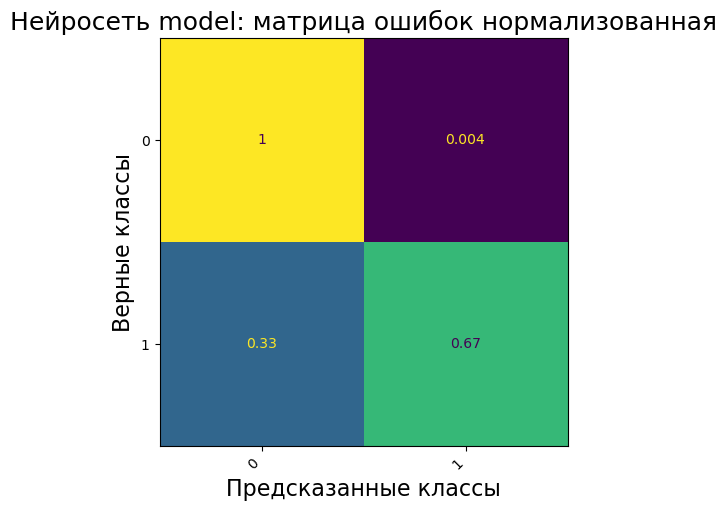

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     67% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  83%
10/10 [==============================] - 2s 238ms/step


INFO:tensorflow:Assets written to: model_plus\assets


INFO:tensorflow:Assets written to: model_plus\assets


Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_78 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_78 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_139 (Ba  (None, 400, 5)           20        
 tchNormalization)                                               
                                                                 
 gru_11 (GRU)                (None, 40)                5640      
                                                                 
 dense_161 (Dense)           (None, 2)                 82        
                                                                 
Total params: 155,742
Trainable params: 155,732
Non-t

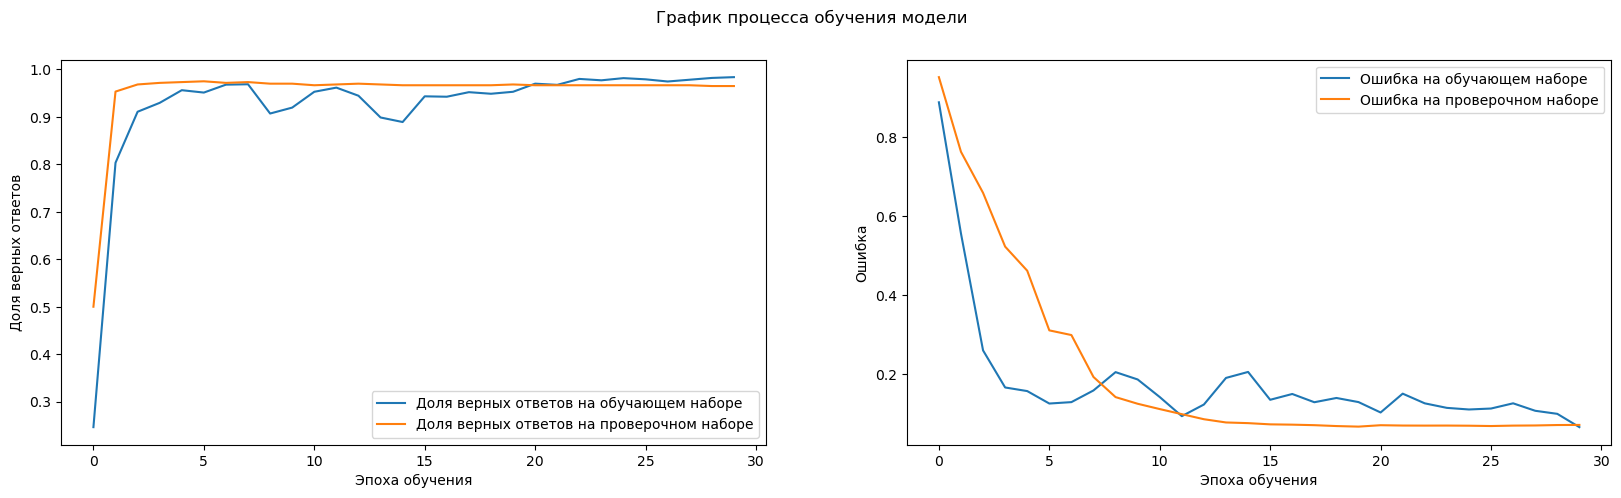

10/10 [==============================] - 3s 249ms/step


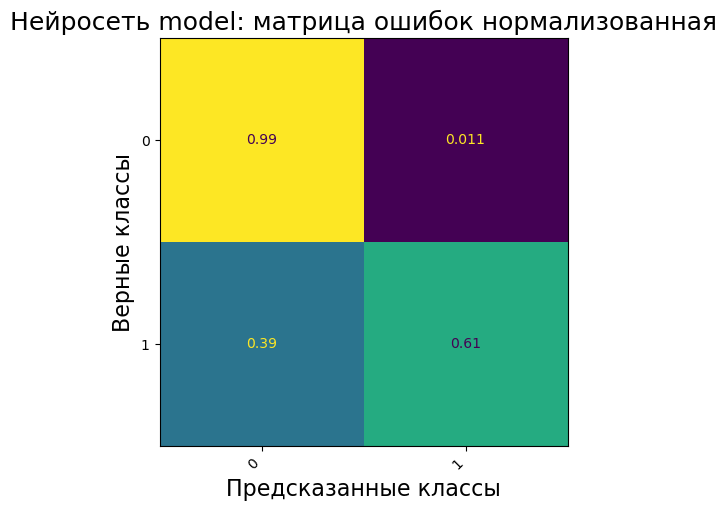

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     99% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     61% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  80%
10/10 [==============================] - 2s 245ms/step
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_79 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_79 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_140 (Ba  (None, 400, 5)           20        
 tchNormalization)                                            

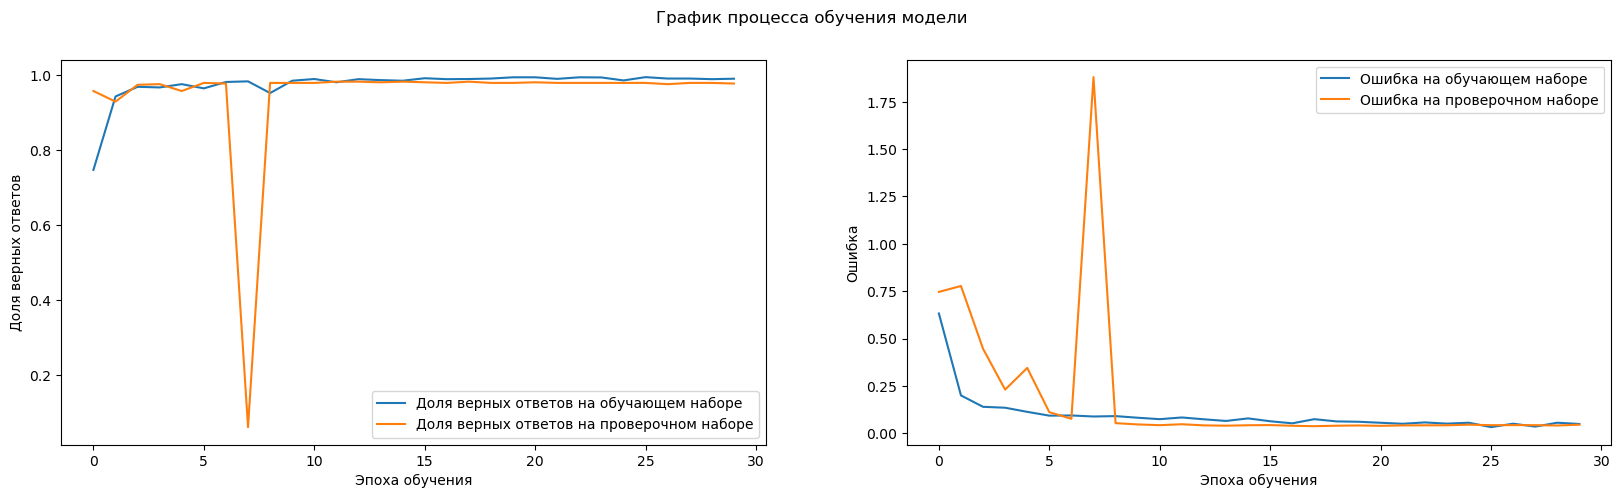

10/10 [==============================] - 3s 312ms/step


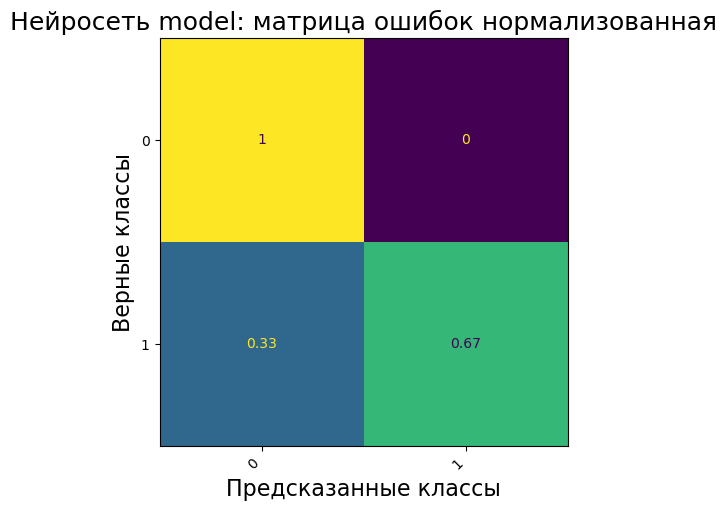

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     67% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  83%
10/10 [==============================] - 3s 310ms/step


INFO:tensorflow:Assets written to: model_plus\assets


INFO:tensorflow:Assets written to: model_plus\assets


Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_80 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_80 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_141 (Ba  (None, 400, 5)           20        
 tchNormalization)                                               
                                                                 
 lstm_36 (LSTM)              (None, 4)                 160       
                                                                 
 dense_163 (Dense)           (None, 2)                 10        
                                                                 
Total params: 150,190
Trainable params: 150,180
Non-t

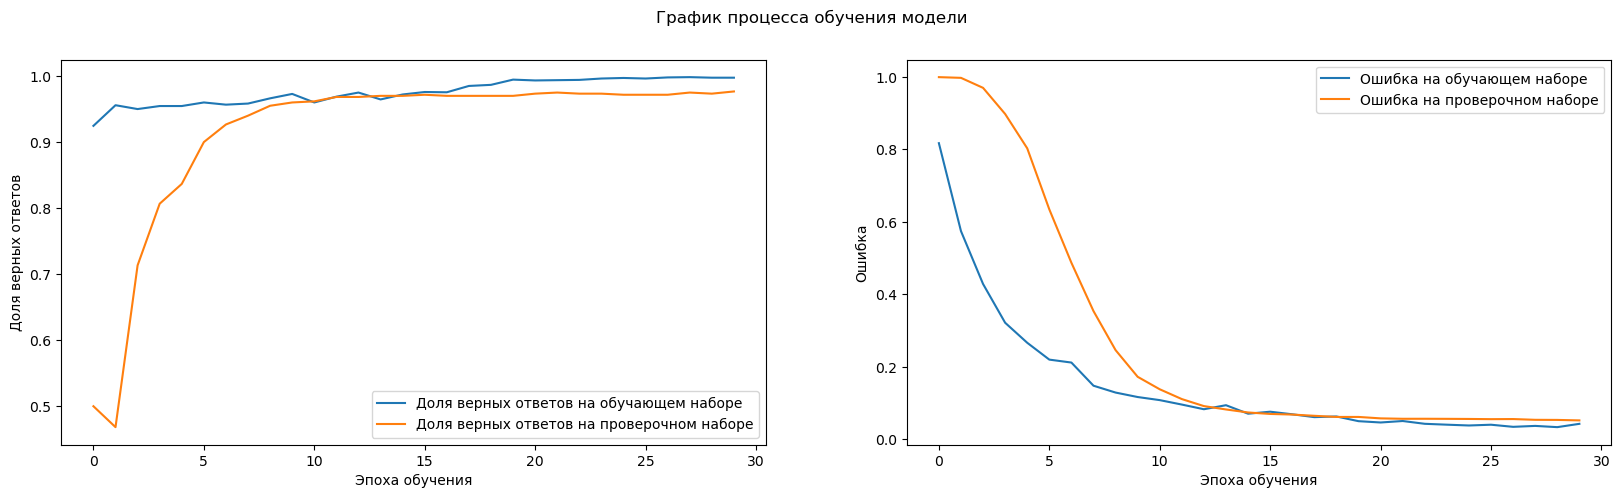

10/10 [==============================] - 1s 89ms/step


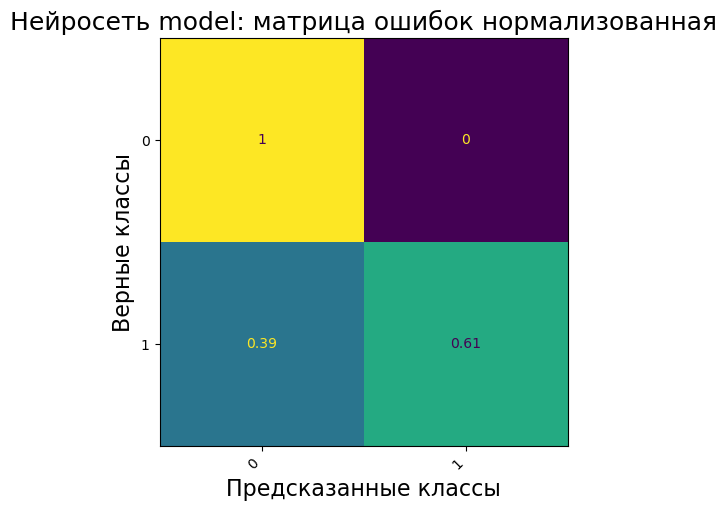

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     61% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  81%
10/10 [==============================] - 1s 83ms/step
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_81 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_81 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_142 (Ba  (None, 400, 5)           20        
 tchNormalization)                                             

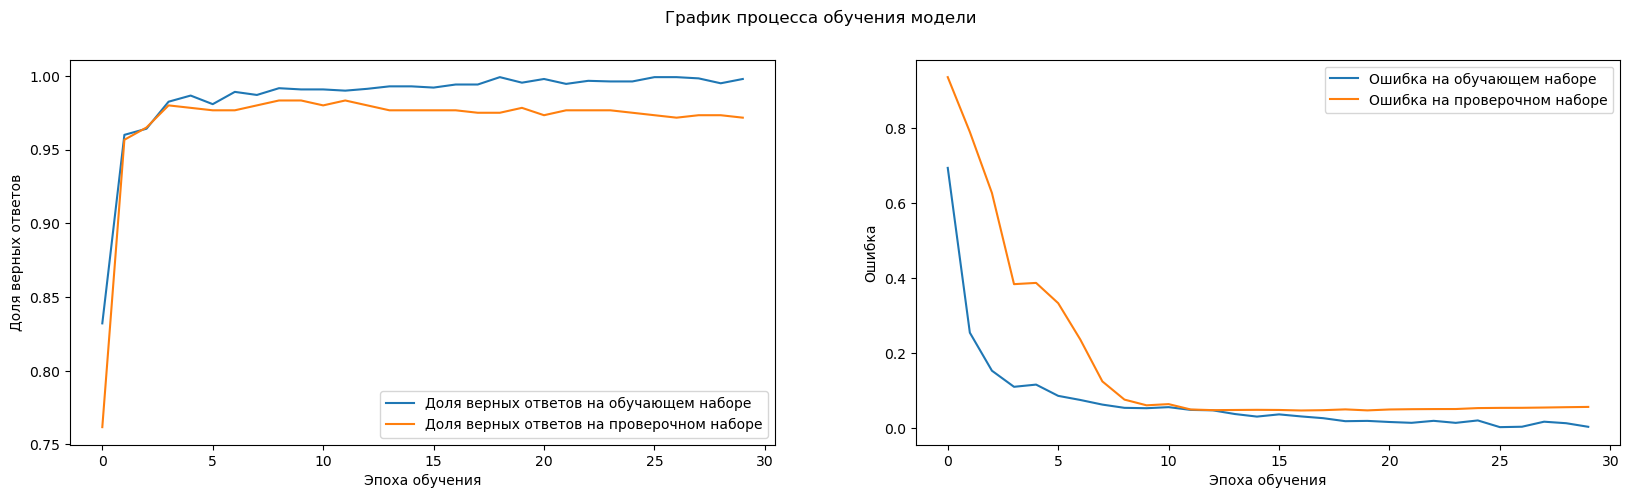

10/10 [==============================] - 1s 84ms/step


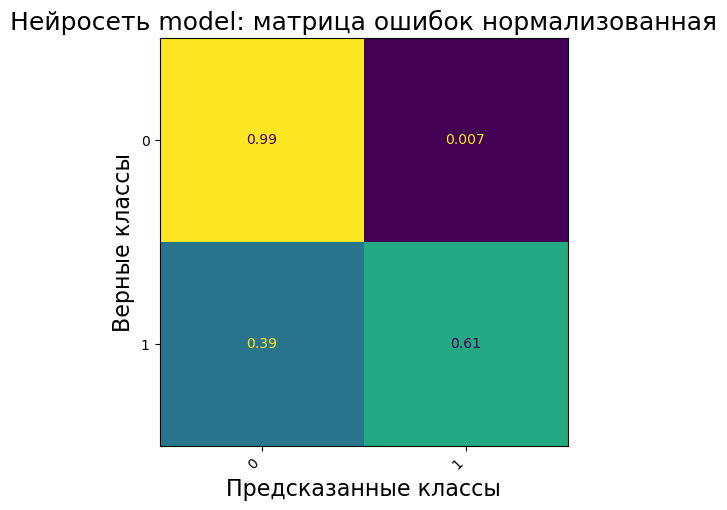

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     99% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     61% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  80%
10/10 [==============================] - 1s 84ms/step
Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_82 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_82 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_143 (Ba  (None, 400, 5)           20        
 tchNormalization)                                             

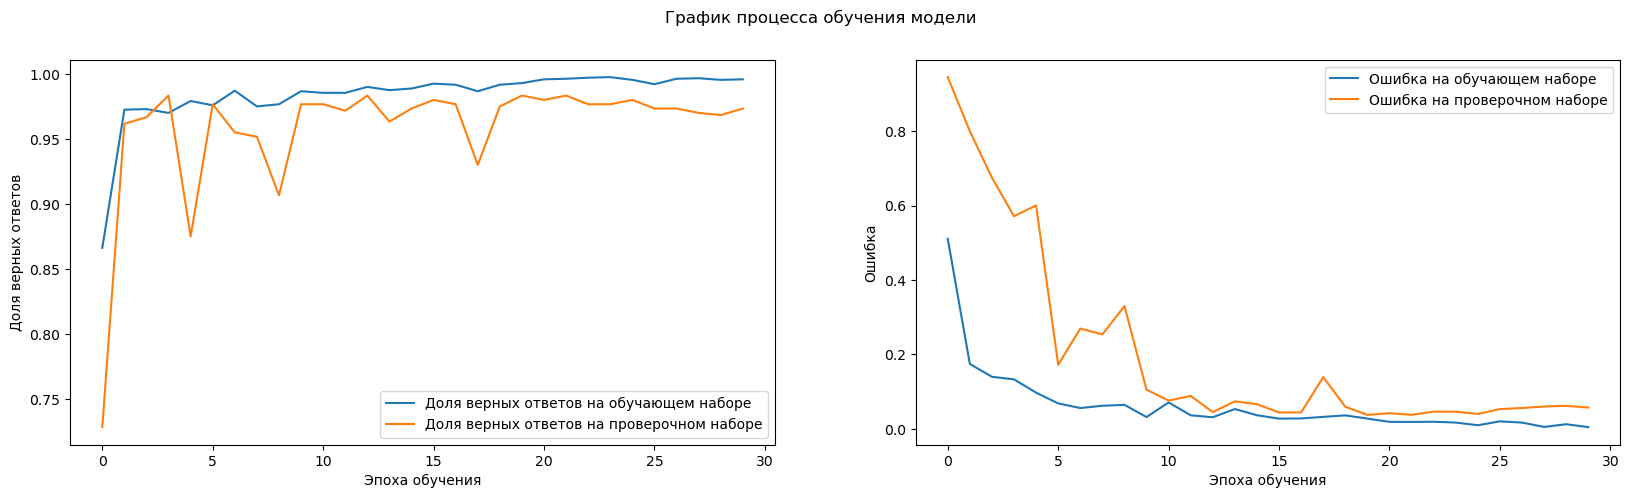

10/10 [==============================] - 4s 386ms/step


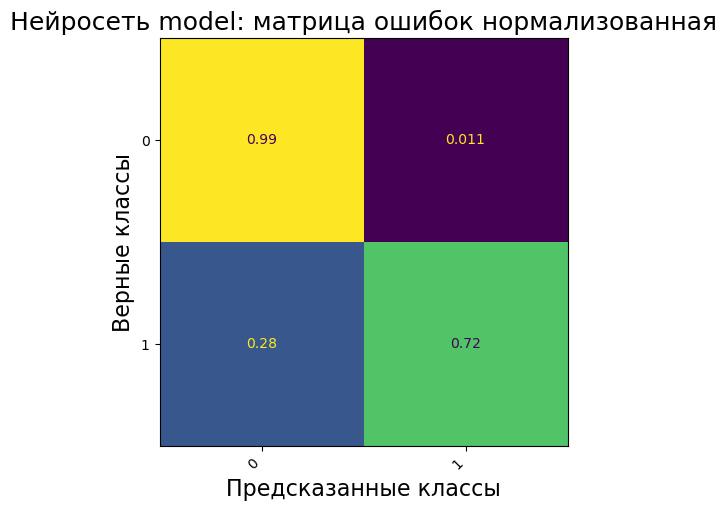

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     99% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     72% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  86%
10/10 [==============================] - 4s 386ms/step


INFO:tensorflow:Assets written to: model_plus\assets


INFO:tensorflow:Assets written to: model_plus\assets


Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_83 (Embedding)    (None, 400, 5)            150000    
                                                                 
 spatial_dropout1d_83 (Spati  (None, 400, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_144 (Ba  (None, 400, 5)           20        
 tchNormalization)                                               
                                                                 
 lstm_39 (LSTM)              (None, 400, 4)            160       
                                                                 
 lstm_40 (LSTM)              (None, 4)                 144       
                                                                 
 dense_166 (Dense)           (None, 2)               

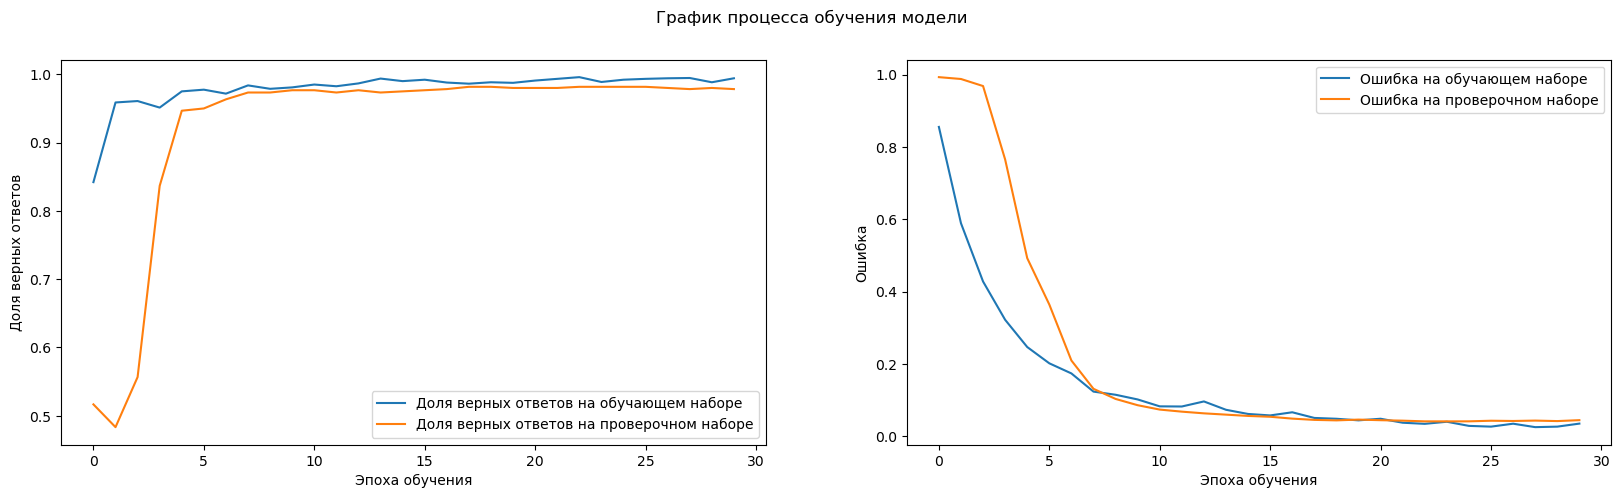

10/10 [==============================] - 2s 154ms/step


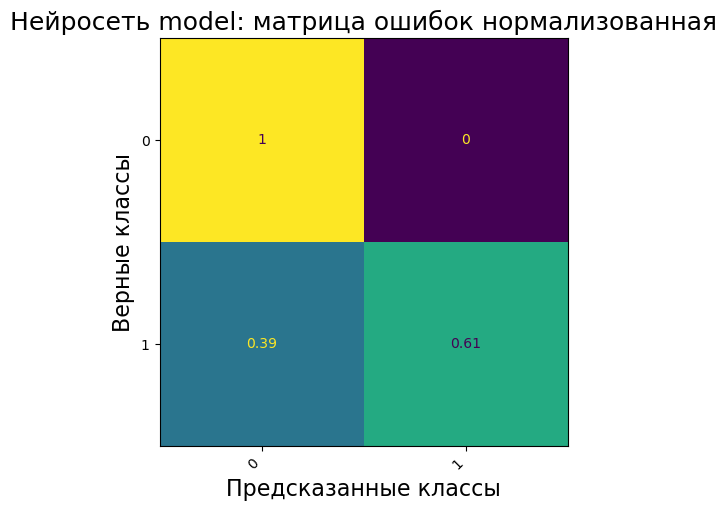

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     61% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  81%
10/10 [==============================] - 2s 152ms/step
Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_84 (Embedding)    (None, 400, 200)          6000000   
                                                                 
 spatial_dropout1d_84 (Spati  (None, 400, 200)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_145 (Ba  (None, 400, 200)         800       
 tchNormalization)                                            

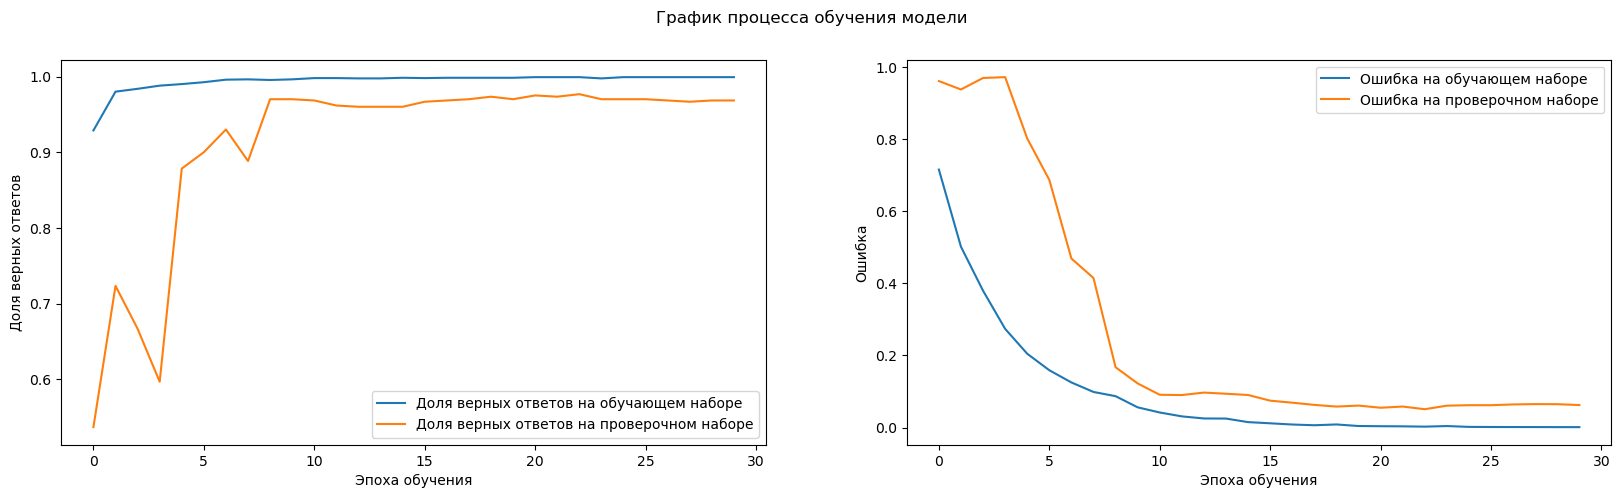

10/10 [==============================] - 2s 134ms/step


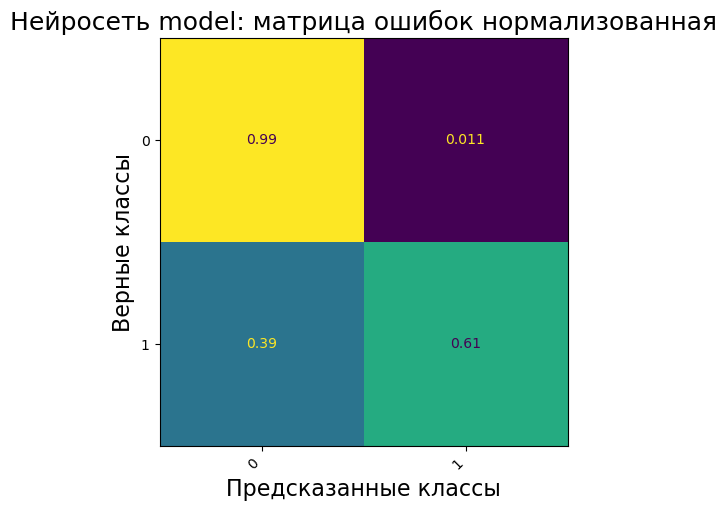

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     99% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     61% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  80%
10/10 [==============================] - 1s 131ms/step
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_85 (Embedding)    (None, 400, 50)           1500000   
                                                                 
 spatial_dropout1d_85 (Spati  (None, 400, 50)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_146 (Ba  (None, 400, 50)          200       
 tchNormalization)                                            

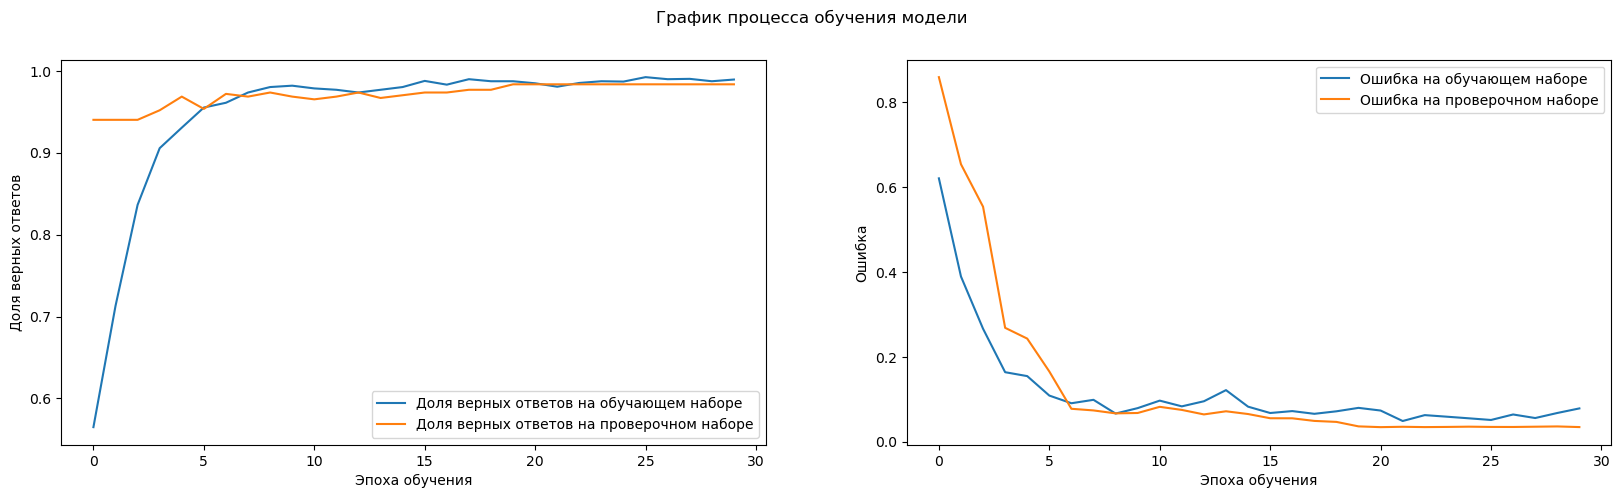

10/10 [==============================] - 7s 529ms/step


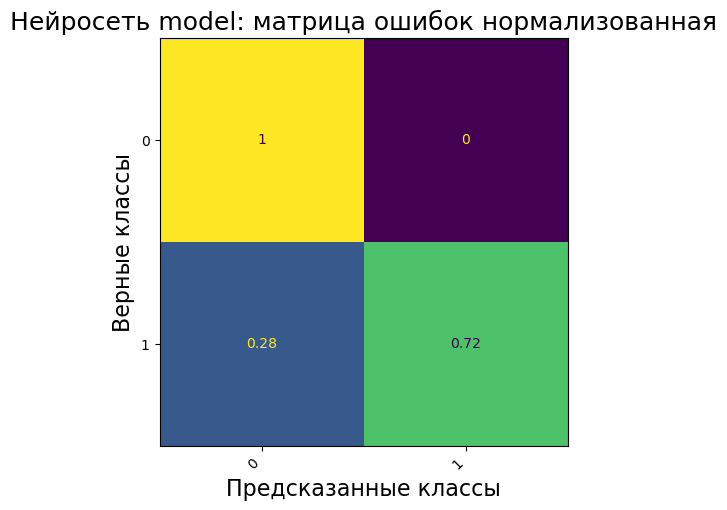

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     72% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  86%
10/10 [==============================] - 5s 525ms/step


INFO:tensorflow:Assets written to: model_plus\assets


INFO:tensorflow:Assets written to: model_plus\assets


Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_86 (Embedding)    (None, 400, 50)           1500000   
                                                                 
 spatial_dropout1d_86 (Spati  (None, 400, 50)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_150 (Ba  (None, 400, 50)          200       
 tchNormalization)                                               
                                                                 
 bidirectional_10 (Bidirecti  (None, 400, 16)          3776      
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 16)               1600      
 onal)                                               

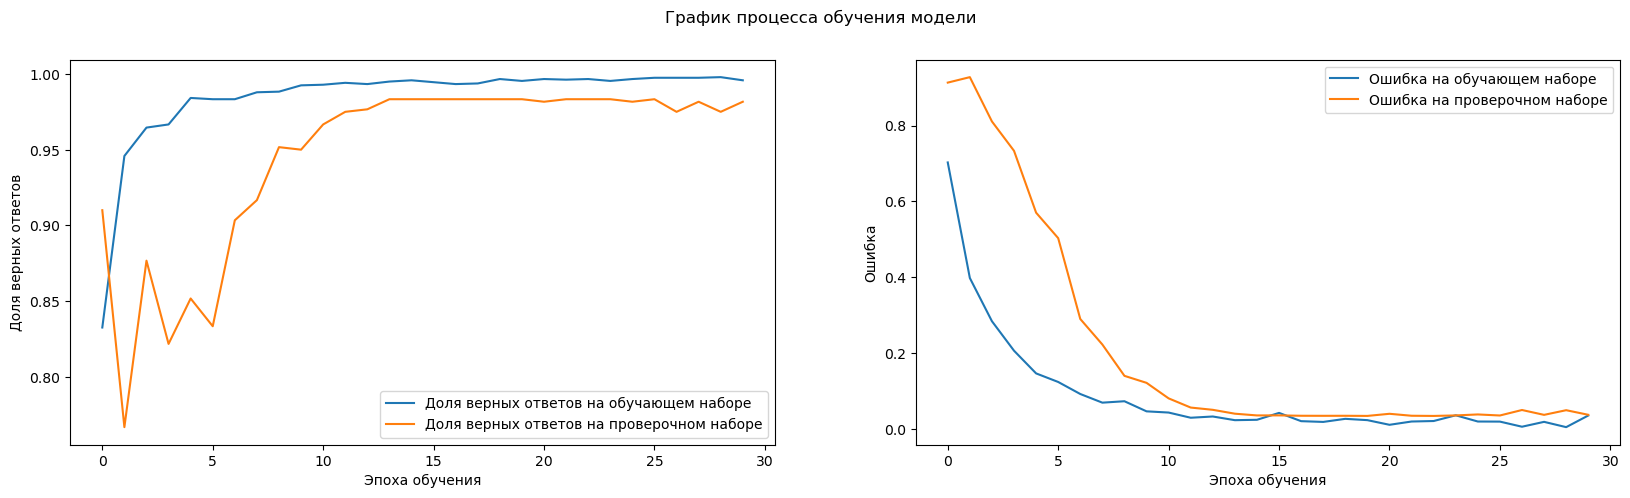

10/10 [==============================] - 10s 866ms/step


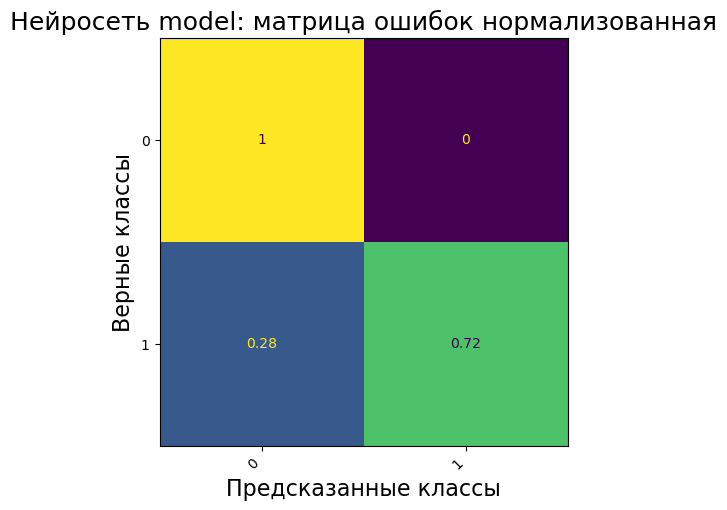

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     72% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  86%
10/10 [==============================] - 9s 938ms/step
Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_87 (Embedding)    (None, 400, 10)           300000    
                                                                 
 spatial_dropout1d_87 (Spati  (None, 400, 10)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_151 (Ba  (None, 400, 10)          40        
 tchNormalization)                                            

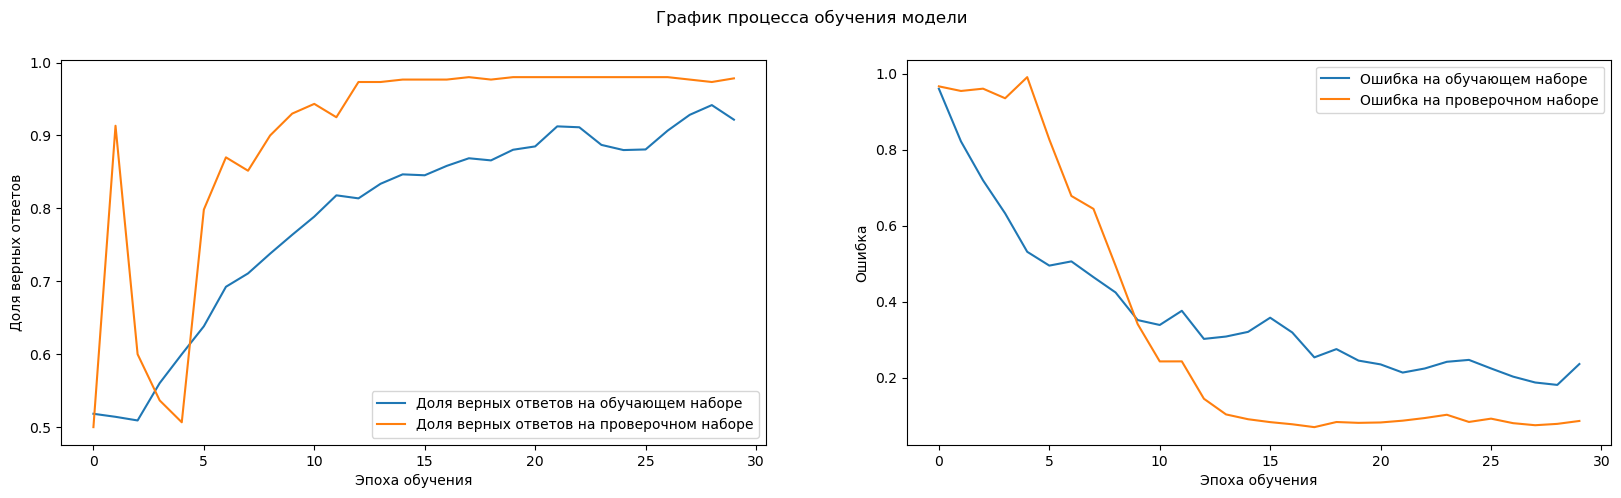

10/10 [==============================] - 2s 143ms/step


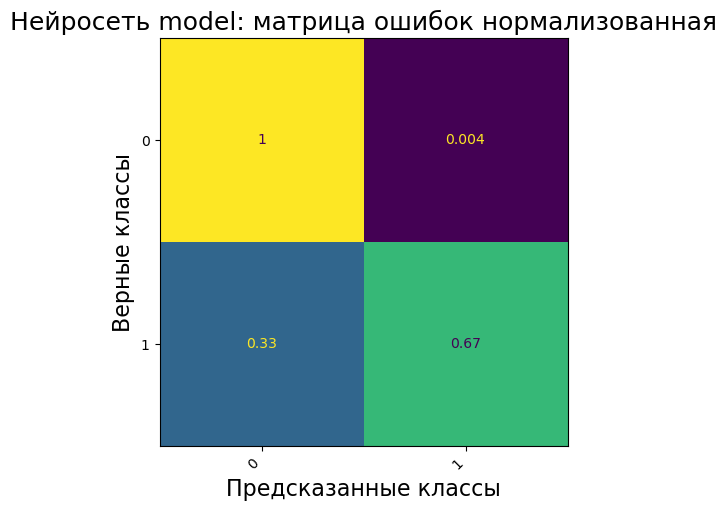

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     67% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  83%
10/10 [==============================] - 1s 140ms/step
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_88 (Embedding)    (None, 400, 10)           300000    
                                                                 
 spatial_dropout1d_88 (Spati  (None, 400, 10)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_154 (Ba  (None, 400, 10)          40        
 tchNormalization)                                            

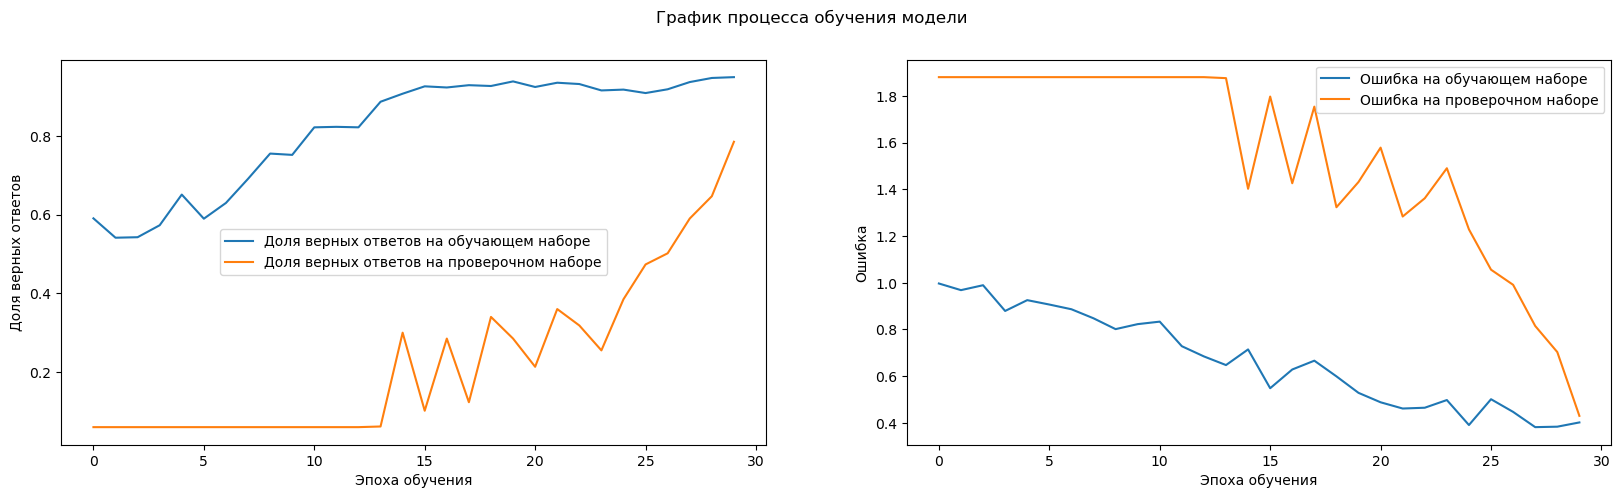

10/10 [==============================] - 2s 192ms/step


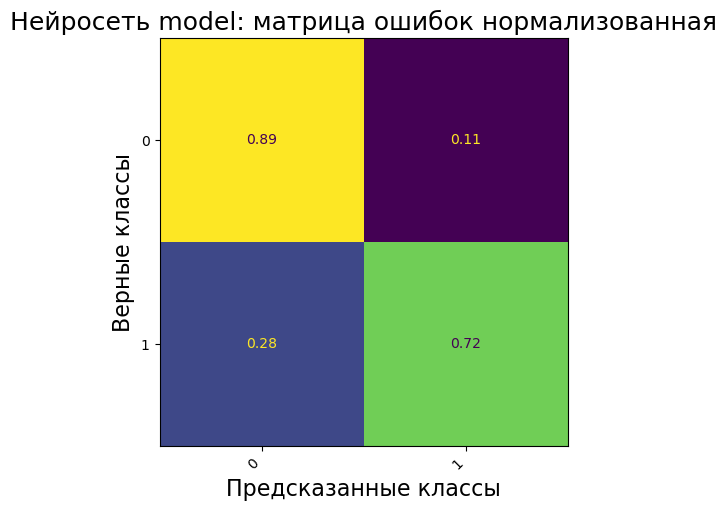

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     89% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     72% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  81%
10/10 [==============================] - 2s 194ms/step
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_89 (Embedding)    (None, 400, 10)           300000    
                                                                 
 spatial_dropout1d_89 (Spati  (None, 400, 10)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_157 (Ba  (None, 400, 10)          40        
 tchNormalization)                                           

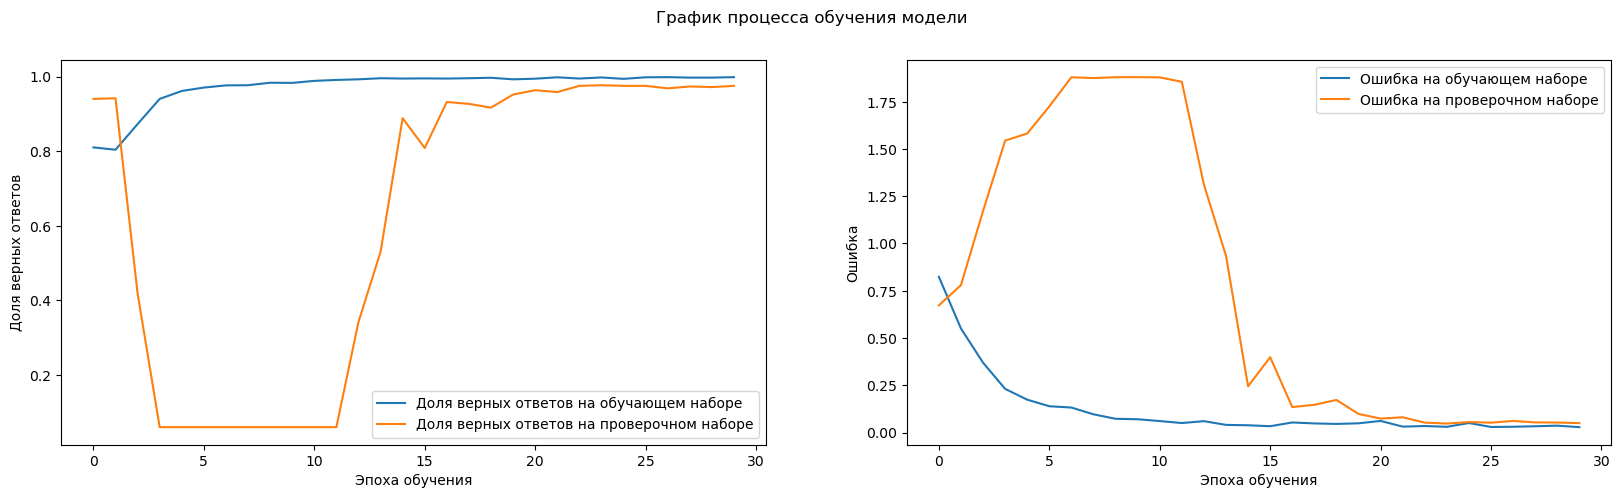

10/10 [==============================] - 0s 26ms/step


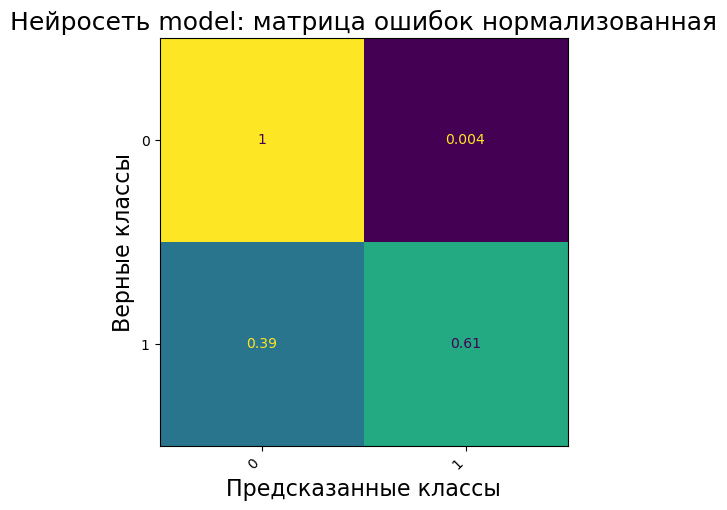

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     61% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  80%
10/10 [==============================] - 0s 27ms/step
Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_90 (Embedding)    (None, 400, 50)           1500000   
                                                                 
 spatial_dropout1d_90 (Spati  (None, 400, 50)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_159 (Ba  (None, 400, 50)          200       
 tchNormalization)                                            

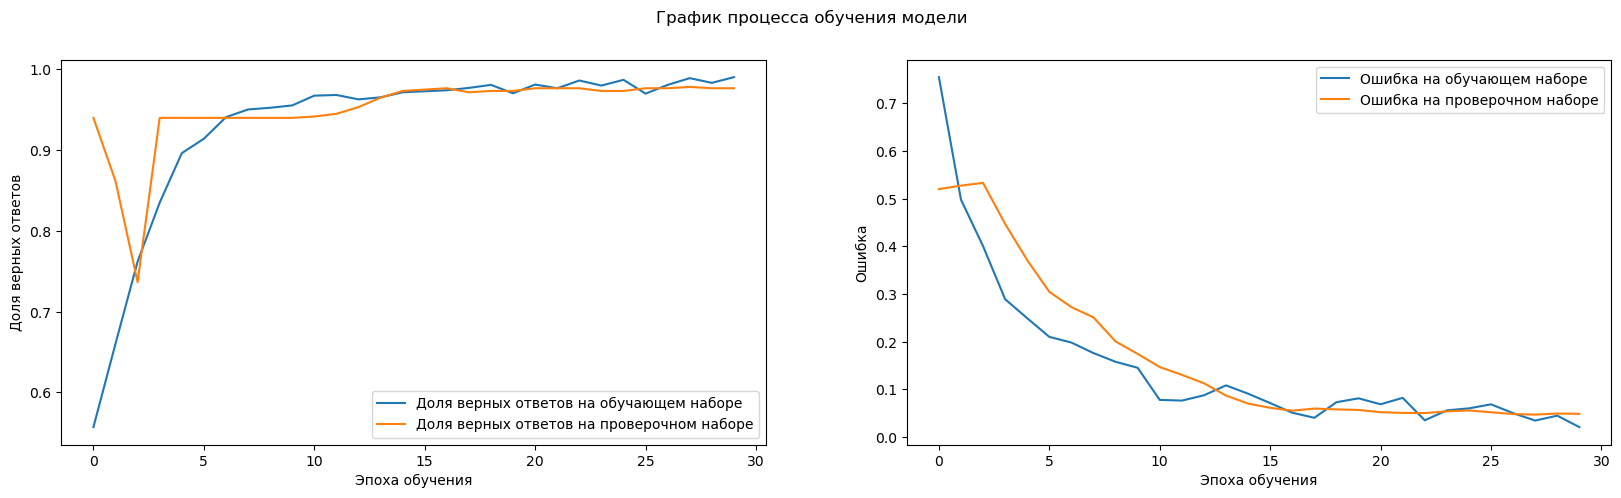

10/10 [==============================] - 1s 50ms/step


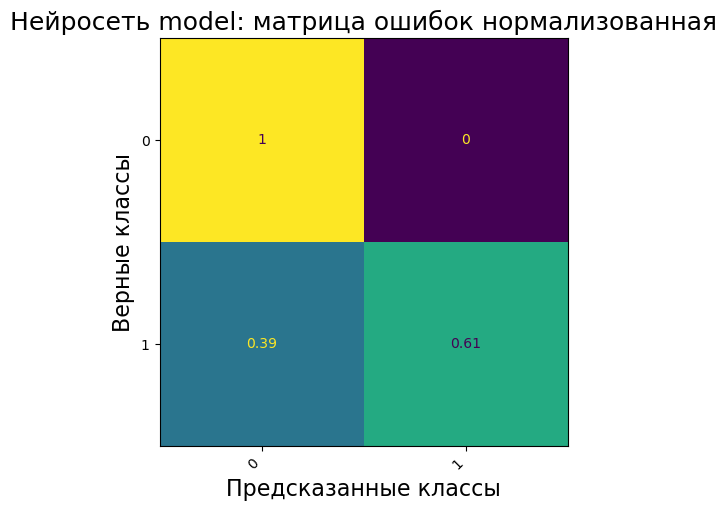

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                    100% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     61% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  81%
10/10 [==============================] - 1s 51ms/step
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_91 (Embedding)    (None, 400, 10)           300000    
                                                                 
 spatial_dropout1d_91 (Spati  (None, 400, 10)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_162 (Ba  (None, 400, 10)          40        
 tchNormalization)                                            

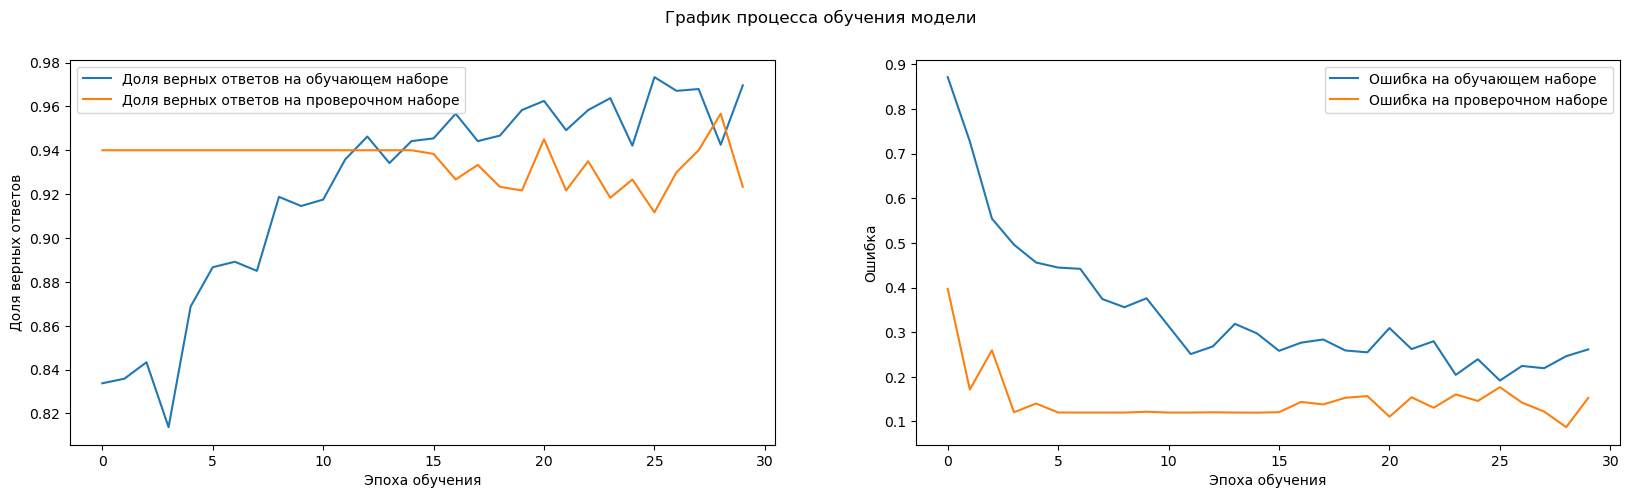

10/10 [==============================] - 1s 47ms/step


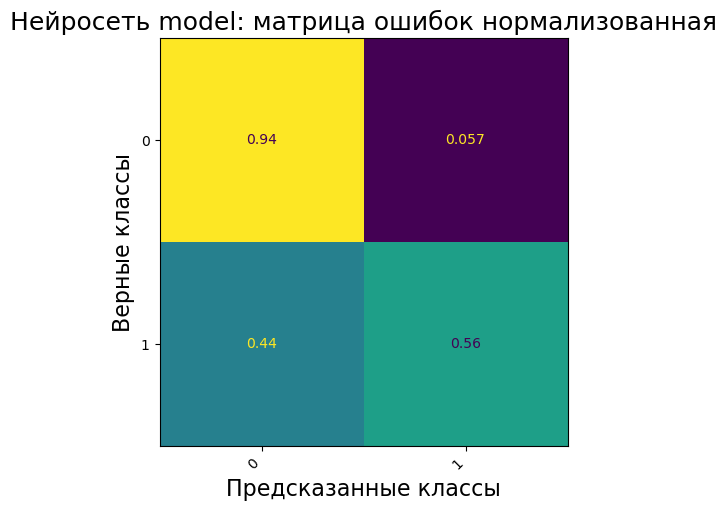

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     94% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     56% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  75%
10/10 [==============================] - 1s 52ms/step
Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_92 (Embedding)    (None, 400, 50)           1500000   
                                                                 
 spatial_dropout1d_92 (Spati  (None, 400, 50)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_166 (Ba  (None, 400, 50)          200       
 tchNormalization)                                            

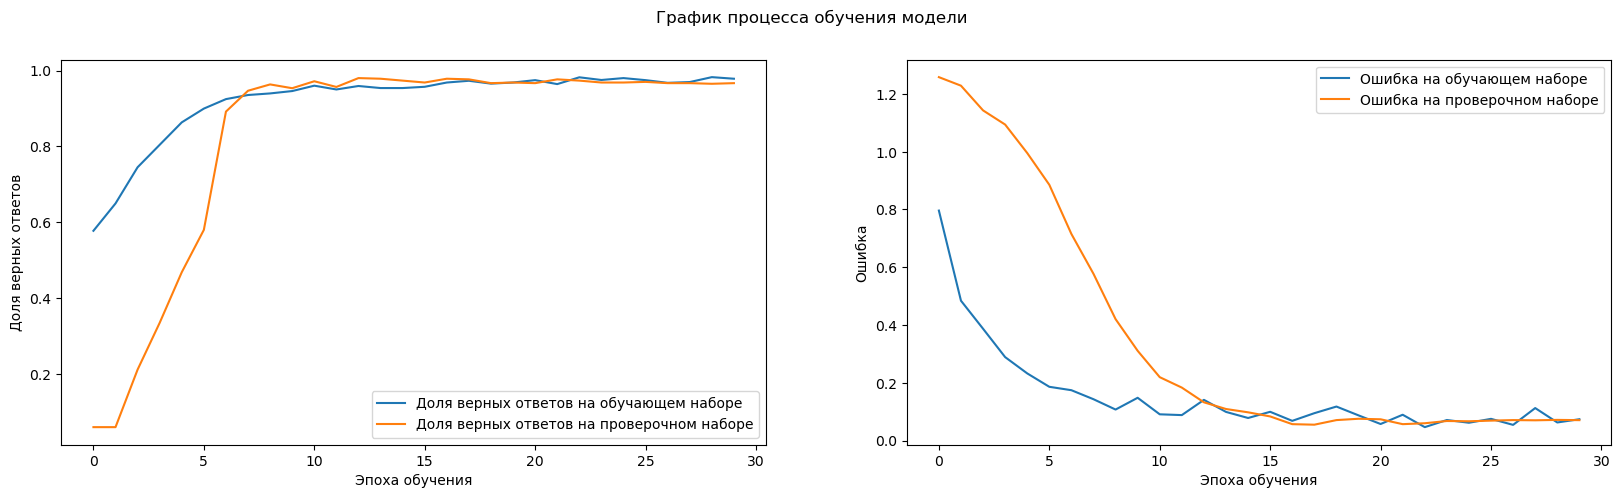

10/10 [==============================] - 0s 34ms/step


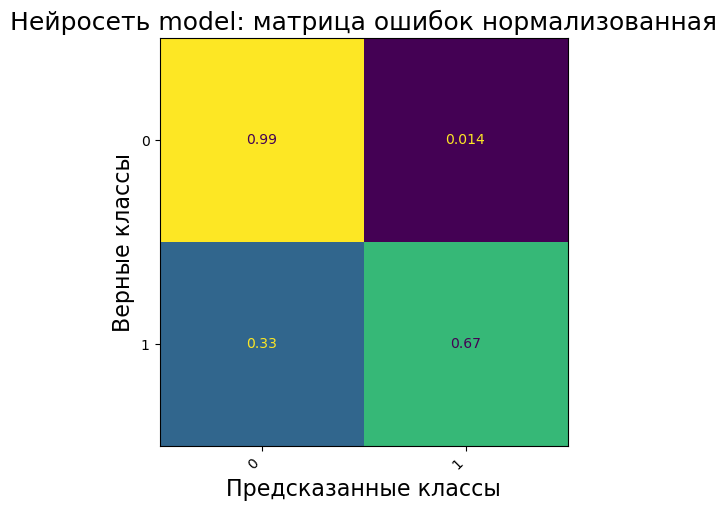

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     99% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     67% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  83%
10/10 [==============================] - 0s 34ms/step
Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_93 (Embedding)    (None, 400, 10)           300000    
                                                                 
 spatial_dropout1d_93 (Spati  (None, 400, 10)          0         
 alDropout1D)                                                    
                                                                 
 lstm_49 (LSTM)              (None, 400, 4)            240       
                                                              

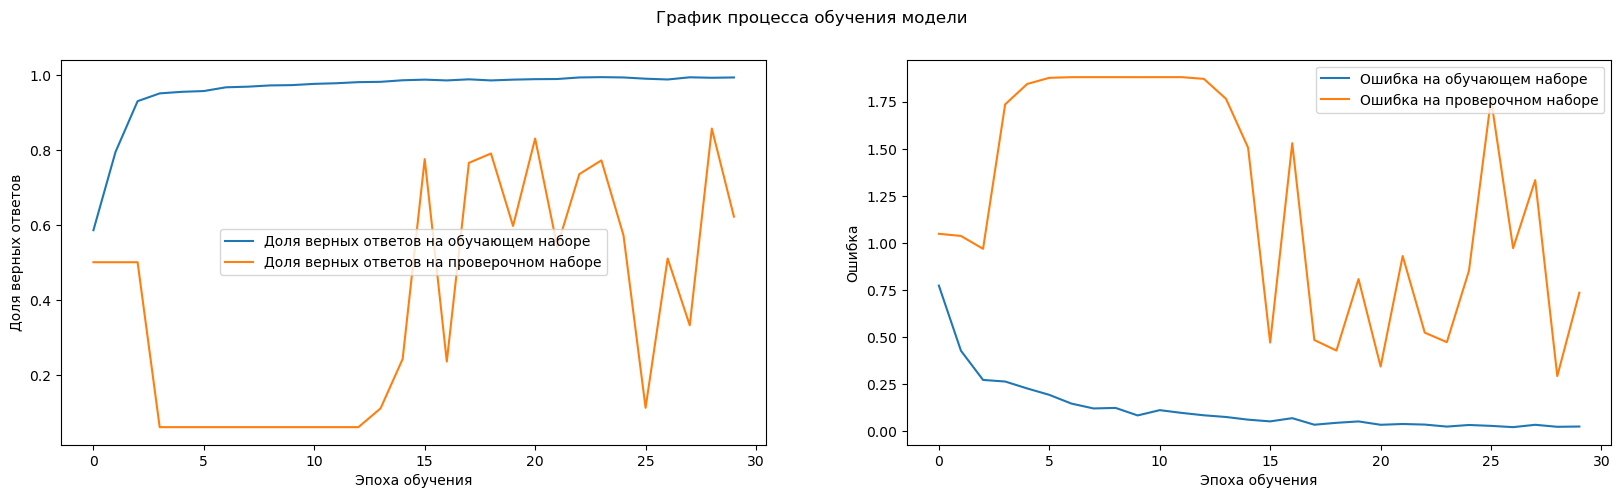

10/10 [==============================] - 12s 296ms/step


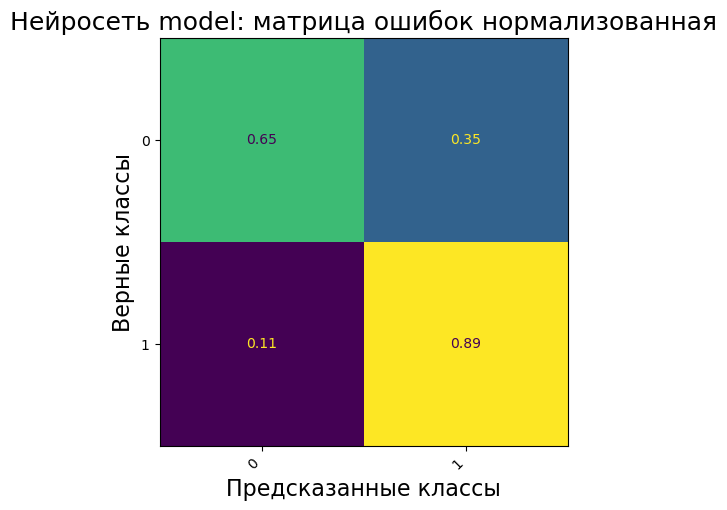

----------------------------------------------------------------------------------------------------
Нейросеть: model
Класс: 0                     64% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     89% сеть отнесла к классу 1                    - ВЕРНО :-)

Средняя точность распознавания:  77%
10/10 [==============================] - 8s 294ms/step
Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_94 (Embedding)    (None, 400, 10)           300000    
                                                                 
 spatial_dropout1d_94 (Spati  (None, 400, 10)          0         
 alDropout1D)                                                    
                                                                 
 lstm_51 (LSTM)              (None, 400, 4)            240       
                                                             

In [ ]:
%%time
score = 0

# SimpleRNN
        # Исследование №1: Embedding(5) + SimpleRNN(4) + Dropout(0.2)
        # Создание последовательной модели нейросети
model_SimpleRNN_1 = Sequential()

        # Слой эмбеддинга преобразует каждое (индекс) в многомерный плотный вектор
        # На входе указываются объем словаря, размерность вектора и длина входных данных
model_SimpleRNN_1.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))

# Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_1.add(SpatialDropout1D(0.2))
        # Слой нормализации данных
model_SimpleRNN_1.add(BatchNormalization())
        # Рекуррентный слой
model_SimpleRNN_1.add(SimpleRNN(4))
        # Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_1.add(Dropout(0.2))
        # Выходной слой классификатора
model_SimpleRNN_1.add(Dense(CLASS_COUNT, activation=activation)) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

model = model_SimpleRNN_1

compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №2: Embedding(5) + SimpleRNN(20) + Dropout(0.2)
        # Создание последовательной модели нейросети
model_SimpleRNN_2 = Sequential()

        # Слой эмбеддинга преобразует каждое (индекс) в многомерный плотный вектор
        # На входе указываются объем словаря, размерность вектора и длина входных данных
model_SimpleRNN_2.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))

        # Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_2.add(SpatialDropout1D(0.2))
        # Слой нормализации данных
model_SimpleRNN_2.add(BatchNormalization())
        # Рекуррентный слой
model_SimpleRNN_2.add(SimpleRNN(20))
        # Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_2.add(Dropout(0.2))
        # Выходной слой классификатора
model_SimpleRNN_2.add(Dense(CLASS_COUNT, activation=activation)) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

model = model_SimpleRNN_2
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №3: Embedding(100) + SimpleRNN(20) + Dropout(0.2)
        # Создание последовательной модели нейросети
model_SimpleRNN_3 = Sequential()

        # Слой эмбеддинга преобразует каждое (индекс) в многомерный плотный вектор
        # На входе указываются объем словаря, размерность вектора и длина входных данных
model_SimpleRNN_3.add(Embedding(VOCAB_SIZE, 100, input_length=seq_max_len))

        # Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_3.add(SpatialDropout1D(0.2))
        # Слой нормализации данных
model_SimpleRNN_3.add(BatchNormalization())
        # Рекуррентный слой
model_SimpleRNN_3.add(SimpleRNN(20))
        # Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_3.add(Dropout(0.2))
        # Выходной слой классификатора
model_SimpleRNN_3.add(Dense(CLASS_COUNT, activation=activation)) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

model = model_SimpleRNN_3
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')




        # Исследование №4: Embedding(5) + SimpleRNN(20) + Dropout(0.4)
        # Создание последовательной модели нейросети
model_SimpleRNN_4 = Sequential()

        # Слой эмбеддинга преобразует каждое (индекс) в многомерный плотный вектор
        # На входе указываются объем словаря, размерность вектора и длина входных данных
model_SimpleRNN_4.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))

        # Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_4.add(SpatialDropout1D(0.4))
        # Слой нормализации данных
model_SimpleRNN_4.add(BatchNormalization())
        # Рекуррентный слой
model_SimpleRNN_4.add(SimpleRNN(20))
        # Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_4.add(Dropout(0.4))
        # Выходной слой классификатора
model_SimpleRNN_4.add(Dense(CLASS_COUNT, activation=activation)) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

model = model_SimpleRNN_4
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')


        # GRU
        # Исследование №5: Embedding(5) + GRU(4/0.2) + Dropout(0.2)
model_GRU_1 = Sequential()
model_GRU_1.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))
model_GRU_1.add(SpatialDropout1D(0.2))
model_GRU_1.add(BatchNormalization())
        # Рекуррентный слой GRU
model_GRU_1.add(GRU(4, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model_GRU_1.add(Dense(CLASS_COUNT, activation=activation))

model = model_GRU_1
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №6: Embedding(5) + GRU(40/0.4) + Dropout(0.2)
model_GRU_2 = Sequential()
model_GRU_2.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))
model_GRU_2.add(SpatialDropout1D(0.2))
model_GRU_2.add(BatchNormalization())
        # Рекуррентный слой GRU
model_GRU_2.add(GRU(40, dropout=0.4, recurrent_dropout=0.4, activation='relu'))
model_GRU_2.add(Dense(CLASS_COUNT, activation=activation))

model = model_GRU_2
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №7: Embedding(5) + GRU(80/0.2) + Dropout(0.2)
model_GRU_3 = Sequential()
model_GRU_3.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))
model_GRU_3.add(SpatialDropout1D(0.2))
model_GRU_3.add(BatchNormalization())
        # Рекуррентный слой GRU
model_GRU_3.add(GRU(80, dropout=0.2, recurrent_dropout=0.2, activation=activation))
model_GRU_3.add(Dense(CLASS_COUNT, activation=activation))

model = model_GRU_3
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')


        # LSTM
        # Исследование №8: Embedding(5) + LSTM(4) + Dropout(0.2)
model_LSTM_1 = Sequential()
model_LSTM_1.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))
model_LSTM_1.add(SpatialDropout1D(0.2))
model_LSTM_1.add(BatchNormalization())
        # Рекуррентный слой LSTM
model_LSTM_1.add(LSTM(4))
model_LSTM_1.add(Dense(CLASS_COUNT, activation=activation))

model = model_LSTM_1
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №9: Embedding(5) + LSTM(20) + Dropout(0.2)
model_LSTM_2 = Sequential() # создаём последовательную модель нейросети
model_LSTM_2.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))
model_LSTM_2.add(SpatialDropout1D(0.2))
model_LSTM_2.add(BatchNormalization())
        # Рекуррентный слой LSTM
model_LSTM_2.add(LSTM(20))
model_LSTM_2.add(Dense(CLASS_COUNT, activation=activation))

model = model_LSTM_2
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')




        # Исследование №10: Embedding(5) + LSTM(100) + Dropout(0.2)
model_LSTM_3 = Sequential()
model_LSTM_3.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))
model_LSTM_3.add(SpatialDropout1D(0.2))
model_LSTM_3.add(BatchNormalization())
        # Рекуррентный слой LSTM
model_LSTM_3.add(LSTM(100))
model_LSTM_3.add(Dense(CLASS_COUNT, activation=activation))

model = model_LSTM_3
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №11: Embedding(5) + LSTM(4)x2 + Dropout(0.2)
model_LSTM_4 = Sequential()
model_LSTM_4.add(Embedding(VOCAB_SIZE, 5, input_length=seq_max_len))
model_LSTM_4.add(SpatialDropout1D(0.2))
model_LSTM_4.add(BatchNormalization())
        # Два рекуррентных слоя LSTM
model_LSTM_4.add(LSTM(4, return_sequences=True))
model_LSTM_4.add(LSTM(4))
model_LSTM_4.add(Dense(CLASS_COUNT, activation=activation))

model = model_LSTM_4
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №12: Embedding(200) + LSTM(4)x2 + Dropout(0.2)
model_LSTM_5 = Sequential()
model_LSTM_5.add(Embedding(VOCAB_SIZE, 200, input_length=seq_max_len))
model_LSTM_5.add(SpatialDropout1D(0.2))
model_LSTM_5.add(BatchNormalization())
        # Два рекуррентных слоя LSTM
model_LSTM_5.add(LSTM(4, return_sequences=True))
model_LSTM_5.add(LSTM(4))
model_LSTM_5.add(Dense(CLASS_COUNT, activation=activation))

model = model_LSTM_5
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №13: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
model_LSTM_6 = Sequential()
model_LSTM_6.add(Embedding(VOCAB_SIZE, 50, input_length=seq_max_len))
model_LSTM_6.add(SpatialDropout1D(0.4))
model_LSTM_6.add(BatchNormalization())
        # Два двунаправленных рекуррентных слоя LSTM
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
        # Два рекуррентных слоя GRU
model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_6.add(GRU(16, reset_after=True))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
        # Дополнительный полносвязный слой
model_LSTM_6.add(Dense(200, activation='relu'))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
model_LSTM_6.add(Dense(CLASS_COUNT, activation=activation))

model = model_LSTM_6
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №14: Embedding(50) + BLSTM(8)x2 + Dropout(0.4, 0.3)
model_LSTM_7 = Sequential()
model_LSTM_7.add(Embedding(VOCAB_SIZE, 50, input_length=seq_max_len))
model_LSTM_7.add(SpatialDropout1D(0.4))
model_LSTM_7.add(BatchNormalization())
        # Два двунаправленных рекуррентных слоя LSTM
model_LSTM_7.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_7.add(Bidirectional(LSTM(8)))
model_LSTM_7.add(Dropout(0.3))
model_LSTM_7.add(Dense(CLASS_COUNT, activation=activation))

model = model_LSTM_7
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №15: Embedding(10) + LSTM(4) + Dense(100)
model_LSTM_8 = Sequential()
model_LSTM_8.add(Embedding(VOCAB_SIZE, 10, input_length=seq_max_len))
model_LSTM_8.add(SpatialDropout1D(0.4))
model_LSTM_8.add(BatchNormalization())
        # Рекуррентный слой LSTM
model_LSTM_8.add(LSTM(4))
model_LSTM_8.add(Dropout(0.5))
model_LSTM_8.add(BatchNormalization())
        # Дополнительный полносвязный слой
model_LSTM_8.add(Dense(100, activation='relu'))
model_LSTM_8.add(Dropout(0.5))
model_LSTM_8.add(BatchNormalization())
model_LSTM_8.add(Dense(CLASS_COUNT, activation=activation))

model = model_LSTM_8
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №16: Embedding(10) + LSTM(4) + Dense(100) + Flatten
model_LSTM_9 = Sequential()
model_LSTM_9.add(Embedding(VOCAB_SIZE, 10, input_length=seq_max_len))
model_LSTM_9.add(SpatialDropout1D(0.4))
model_LSTM_9.add(BatchNormalization())
        # Рекуррентный слой LSTM
model_LSTM_9.add(LSTM(4, return_sequences=True))
model_LSTM_9.add(Dropout(0.5))
model_LSTM_9.add(BatchNormalization())
        # Дополнительный полносвязный слой
model_LSTM_9.add(Dense(100, activation='relu'))
model_LSTM_9.add(Dropout(0.5))
model_LSTM_9.add(BatchNormalization())
        # Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_LSTM_9.add(Flatten())
model_LSTM_9.add(Dense(CLASS_COUNT, activation=activation))

model = model_LSTM_9
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Conv1D
        # Исследование №17: Conv1D №1
model_Conv_1 = Sequential()
model_Conv_1.add(Embedding(VOCAB_SIZE, 10, input_length=seq_max_len))
model_Conv_1.add(SpatialDropout1D(0.2))
model_Conv_1.add(BatchNormalization())
        # Два слоя одномерной свертки Conv1D
model_Conv_1.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv_1.add(Conv1D(20, 5, activation='relu'))
        # Слой подвыборки/пулинга с функцией максимума
model_Conv_1.add(MaxPooling1D(2)) 
model_Conv_1.add(Dropout(0.2))
model_Conv_1.add(BatchNormalization())
model_Conv_1.add(Flatten())
model_Conv_1.add(Dense(CLASS_COUNT, activation=activation))

model = model_Conv_1
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №18: Conv1D №2
model_Conv_2 = Sequential()
model_Conv_2.add(Embedding(VOCAB_SIZE, 50, input_length=seq_max_len))
model_Conv_2.add(SpatialDropout1D(0.2))
model_Conv_2.add(BatchNormalization())
        # Два слоя одномерной свертки Conv1D
model_Conv_2.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv_2.add(Conv1D(20, 5, activation='relu', padding='same'))
        # Слой подвыборки/пулинга с функцией максимума
model_Conv_2.add(MaxPooling1D(2))
model_Conv_2.add(Dropout(0.2))
model_Conv_2.add(BatchNormalization())
        # Слой глобального пулинга с функцией максимума
model_Conv_2.add(GlobalMaxPooling1D())
model_Conv_2.add(Dense(20, activation='relu'))
model_Conv_2.add(Dropout(0.2))
model_Conv_2.add(BatchNormalization())
model_Conv_2.add(Dense(CLASS_COUNT, activation=activation))

model = model_Conv_2
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')



        # Исследование №19: Conv1D №3
model_Conv_3 = Sequential()
model_Conv_3.add(Embedding(VOCAB_SIZE, 10, input_length=seq_max_len))
model_Conv_3.add(SpatialDropout1D(0.2))
model_Conv_3.add(BatchNormalization())
        # Два слоя одномерной свертки Conv1D
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
        # Слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(MaxPooling1D(2))
model_Conv_3.add(Dropout(0.2))
model_Conv_3.add(BatchNormalization())
        # Два слоя одномерной свертки Conv1D
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
        # Слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(MaxPooling1D(2))
model_Conv_3.add(Dropout(0.2))
model_Conv_3.add(BatchNormalization())
        # Два слоя одномерной свертки Conv1D
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
        # Слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(MaxPooling1D(2))
model_Conv_3.add(Dropout(0.2))
model_Conv_3.add(BatchNormalization())
        # Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_Conv_3.add(Flatten())
model_Conv_3.add(Dense(64, activation='relu'))
model_Conv_3.add(Dense(CLASS_COUNT, activation=activation))

model = model_Conv_3
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')




        # Исследование №20: Conv1D №4
model_Conv_4 = Sequential()
model_Conv_4.add(Embedding(VOCAB_SIZE, 50, input_length=seq_max_len))
model_Conv_4.add(SpatialDropout1D(0.2))
model_Conv_4.add(BatchNormalization())
        # Слой одномерной свертки Conv1D
model_Conv_4.add(Conv1D(20, 5, activation='relu'))
        # Слой подвыборки/пулинга с функцией максимума
model_Conv_4.add(MaxPooling1D(2))
model_Conv_4.add(Dropout(0.2))
model_Conv_4.add(BatchNormalization())
        # Слой глобального пулинга с функцией максимума
model_Conv_4.add(GlobalMaxPooling1D())
        # Дополнительный полносвязный слой
model_Conv_4.add(Dense(20, activation='relu'))
model_Conv_4.add(Dropout(0.2))
model_Conv_4.add(BatchNormalization())
model_Conv_4.add(Dense(CLASS_COUNT, activation=activation))

model = model_Conv_4
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')




        # LSTM + Conv1D
        # Исследование №21: LSTM + Conv1D №1
model_LC_1 = Sequential()
model_LC_1.add(Embedding(VOCAB_SIZE, 10, input_length=seq_max_len))
model_LC_1.add(SpatialDropout1D(0.2))
        # Рекуррентный слой LSTM
model_LC_1.add(LSTM(4, return_sequences=1))
        # Полносвязный слой
model_LC_1.add(Dense(100, activation='relu'))
        # Сверточный слой
model_LC_1.add(Conv1D(20, 5, activation='relu'))
        # Рекуррентный слой LSTM
model_LC_1.add(LSTM(4, return_sequences=1))
        # Слой регуляризации Dropout
model_LC_1.add(Dropout(0.2)) 
        # Слой пакетной нормализации
model_LC_1.add(BatchNormalization())
        # Два сверточных слоя
model_LC_1.add(Conv1D(20, 5, activation='relu'))
model_LC_1.add(Conv1D(20, 5, activation='relu'))
        # Слой подвыборки/пулинга с функцией максимума
model_LC_1.add(MaxPooling1D(2))
model_LC_1.add(Dropout(0.2))
model_LC_1.add(BatchNormalization())
        # Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_LC_1.add(Flatten())
model_LC_1.add(Dense(CLASS_COUNT, activation=activation))

model = model_LC_1
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')




        # Исследование №22: LSTM + Conv1D №2
model_LC_2 = Sequential()
model_LC_2.add(Embedding(VOCAB_SIZE, 10, input_length=seq_max_len))
model_LC_2.add(SpatialDropout1D(0.2))
        # Рекуррентный слой LSTM
model_LC_2.add(LSTM(4, return_sequences=1))
        # Полносвязный слой
model_LC_2.add(Dense(100, activation='relu'))
        # Сверточный слой
model_LC_2.add(Conv1D(20, 5, activation='relu'))
        # Рекуррентный слой LSTM
model_LC_2.add(LSTM(4, return_sequences=1))
        # Слой подвыборки/пулинга с функцией максимума
model_LC_2.add(MaxPooling1D(2))
model_LC_2.add(Dropout(0.2))
model_LC_2.add(BatchNormalization())
        # Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_LC_2.add(Flatten())
model_LC_2.add(Dense(CLASS_COUNT, activation=activation))

model = model_LC_2
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')




        # Исследование №23: LSTM + Conv1D №3
model_LC_3 = Sequential()
model_LC_3.add(Embedding(VOCAB_SIZE, 10, input_length=seq_max_len))
model_LC_3.add(SpatialDropout1D(0.2))
        # Сверточный слой
model_LC_3.add(Conv1D(20, 5, activation='relu'))
        # Слой подвыборки/пулинга с функцией максимума
model_LC_3.add(MaxPooling1D(2))
        # Слой регуляризации Dropout
model_LC_3.add(Dropout(0.2))
        # Слой пакетной нормализации
model_LC_3.add(BatchNormalization())
        # Рекуррентный слой LSTM
model_LC_3.add(LSTM(4, return_sequences=1))
model_LC_3.add(Dropout(0.2))
model_LC_3.add(BatchNormalization())
        # Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_LC_3.add(Flatten())
model_LC_3.add(Dense(CLASS_COUNT, activation=activation))

model = model_LC_3
compile_train_eval_model(model,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         optimizer='rmsprop', # 'rmsprop', 'adam'
                         epochs=30,
                         batch_size=32,
                         cm_size=(8, 6),
                         class_labels=CLASS_LIST,
                         title='model')

y_pred = model.predict(x_test_clip)
    # Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
if score < (cm[0][0]+cm[1][1])/2:
    score = (cm[0][0]+cm[1][1])/2
    # save
    model.save('model_plus')


# Тест

47/47 [==============================] - 0s 3ms/step


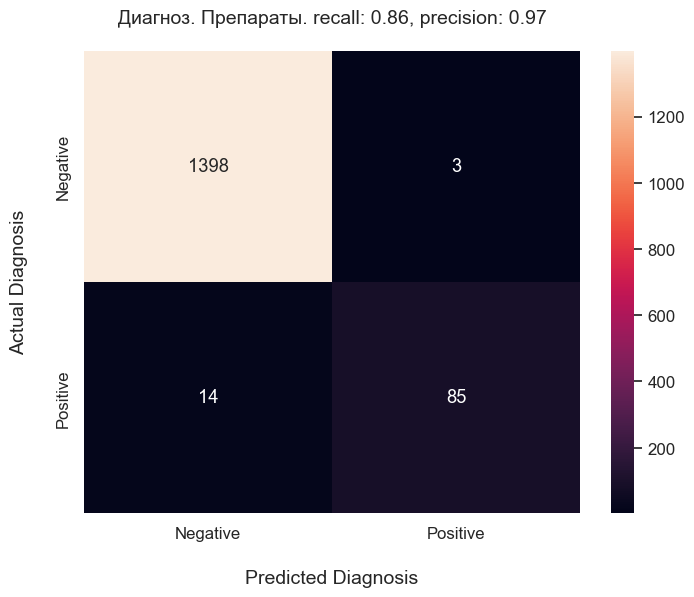

In [2]:
def test(data='data.xlsx', percent_score=False):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import tensorflow
    import pickle
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import confusion_matrix, precision_score, recall_score
    
    # Предобработка
    text_data = pd.read_excel(data)['Диагноз'].tolist()
    
    # Загружаем сохраненный Tokenizer из файла
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Преобразование входных текстов в последовательности индексов (для архитектур с embedding)
    # Применено приведение к массиву объектов для дальнейшего разделения на выборки
    x_data = np.array(tokenizer.texts_to_sequences(text_data), dtype=object)

    # Снижение размерности входных данных:
    # ограничение длины последовательностей до разумного предела
    seq_max_len = 400
    x_test_clip = tensorflow.keras.preprocessing.sequence.pad_sequences(x_data, maxlen=seq_max_len)

    model_loaded = tensorflow.keras.models.load_model('model_text_emb_dense')
    pred = model_loaded.predict(x_test_clip)
    pred = tensorflow.sigmoid(pred)

    ##############################################################################################

    # Тест

    class_data = pd.read_excel(data)['target'].tolist()
    # Кодирование меток классов индексами (числами)
    encoder = LabelEncoder()
    class_labels = encoder.fit_transform(class_data)

    CLASS_LIST = encoder.classes_
    CLASS_COUNT = len(CLASS_LIST)
    # Преобразование меток класса к векторам one hot encoding
    y_data = tensorflow.keras.utils.to_categorical(class_labels, CLASS_COUNT)

    y_test, y_pred = np.argmax(pred, axis=1), np.argmax(y_data, axis=1)
    
    # проверим модель на эффективность. Выводим матрицу ошибок
    recall = ("recall: %.2f" % recall_score(y_test, y_pred))
    precision = ("precision: %.2f" % precision_score(y_test, y_pred))

    plt.figure(figsize=(8,6), dpi=100)
    sns.set(font_scale = 1.1)
    if percent_score:
        cm = confusion_matrix(np.argmax(y_data, axis=1),
                      np.argmax(pred, axis=1),
                      normalize='true')
        ax = sns.heatmap(cm, annot=True)
    else:
        ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', )
    ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    ax.set_title(f"Диагноз. Препараты. {recall}, {precision}", fontsize=14, pad=20)
    plt.show()

test(percent_score=False)


In [1]:
# Программа. Алгоритм предобработки и прогноза
text = '''
def predict_proba(data):
    
    import numpy as np
    import pandas as pd
    import tensorflow
    import pickle
    
    # Предобработка
    text_data = [data]
    
    # Загружаем сохраненный Tokenizer из файла
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Преобразование входных текстов в последовательности индексов (для архитектур с embedding)
    # Применено приведение к массиву объектов для дальнейшего разделения на выборки
    x_data = np.array(tokenizer.texts_to_sequences(text_data), dtype=object)

    # Снижение размерности входных данных:
    # ограничение длины последовательностей до разумного предела
    seq_max_len = 400
    x_test_clip = tensorflow.keras.preprocessing.sequence.pad_sequences(x_data, maxlen=seq_max_len)

    model_loaded = tensorflow.keras.models.load_model('model.h5')
    pred = model_loaded.predict(x_test_clip)
    pred = tensorflow.sigmoid(pred)
    
    return np.array(pred)[0][1]

'''
# сохранение
with open('model.py', 'w+', encoding="utf-8",) as f:  
    f.write(text.strip())   


# Тест
import model
d = 'Атрезия легочной артерии 1 тип ; Перимембранозный приточный дефект межжелудочковой перегороки (некоммитированный); Открытое овальное окно. Стеноз устья левой легочной артерии, умеренная гипоплазия левой легочной артерии; Дискордантное отхождение аорты от правого желудочка; Состояние после операции (24.02.2016) наложение модифицированного подключично-легочного анастомоза по Blalock справа; Большая аорто-легочная коллатеральная артерия к правому легкому; Операция (12.12.2016) перевязка ранее наложенного анастомоза по Blalock справа; реконструкция путей оттока из правого желудочка кондуитом из яремной вены быка, в условиях ИК и гипотермии; Недостаточность кровообращения 2-б степени'

model.predict_proba(d)


1/1 [==============================] - 0s 90ms/step


0.2708283

In [5]:
pip freeze

absl-py==1.4.0
aiohttp==3.8.4
aiosignal==1.3.1
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
altair==4.2.2
anaconda-client==1.11.1
anaconda-navigator==2.4.0
anaconda-project @ file:///C:/Windows/TEMP/abs_91fu4tfkih/croots/recipe/anaconda-project_1660339890874/work
anyio @ file:///C:/ci/anyio_1644481856696/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644569876605/work
arrow @ file:///C:/b/abs_cal7u12ktb/croot/arrow_1676588147908/work
astroid @ file:///C:/b/abs_d4lg3_taxn/croot/astroid_1676904351456/work
astropy @ file:///C:/ci/astropy_1657719642921/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-timeout==4.0.2
atomicwrites==1.4.0
attrs @ file:///C:/b/abs_09s3y775ra/croot/attrs_1668696195628/work
Automat @ file:///tmp/build/80754af9/automat_1600298431173/work
autopep8 @ file:///opt/conda/conda-bld/autopep8_